## Project 4: Kaggle West Nile Virus EDA

Sian Lewis, Raj Chakrabarty, Zaheer Rangwala, Joshua Sung

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/joshsungasong/anaconda3/lib/python3.6/site-packages/pandas_profiling/base.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/joshsungasong/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/joshsungasong/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/joshsungasong/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/joshsungasong/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/joshsungasong/anaconda3/lib/python3.6/site-pac

In [110]:
train = pd.read_csv('./west_nile/input/train.csv')
test = pd.read_csv('./west_nile/input/test.csv', index_col='Id')
weather = pd.read_csv('./west_nile/input/weather.csv')
spray = pd.read_csv('./west_nile/input/spray.csv')

In [111]:
pandas_profiling.ProfileReport(train)

In [112]:
pandas_profiling.ProfileReport(test)

In [113]:
pandas_profiling.ProfileReport(weather)

In [114]:
pandas_profiling.ProfileReport(spray)

### Weather data frame cleaning

In [7]:
weather.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

     ...    CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0    ...                0      M      0.0        0.00       29.10    29.82   
1    ...                M      M        M        0.00       29.18    29.82   
2    ...         BR     0      M      0.0        0.00       29.38    30.09   
3    ...      BR HZ     M      M        M        0.00       29.44    30.08   
4    ...                0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [8]:
weather.dtypes #We're going to need to convert the object Data series into floats, integers. 

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [9]:
weather = weather[weather['Station'] == 1] #Going to utilize station 1 (Chicago O'Hare International) since incorporating
#both stations would double the data

In [10]:
#We want to convert the Date to a date-time series and also convert M values in the WetBulb data series into a null
#value since M values are designated as 'missing'. Then we want to convert it into an integer data type. 
weather['Date'] = pd.to_datetime(weather['Date'])
weather['WetBulb'] = weather['WetBulb'].apply(lambda x: np.nan if x == 'M' else x)
weather['WetBulb'] = weather['WetBulb'].astype(float)

In [11]:
weather['Tmin'] = weather['Tmin'].astype(float)
weather['Tmax'] = weather['Tmax'].astype(float)
weather['DewPoint'] = weather['DewPoint'].astype(float)

In [12]:
weather['Heat'] = weather['Heat'].apply(lambda x: np.nan if x == 'M' else x)
weather['Heat'] = weather['Heat'].astype(float) #Same thing with Heat as with WetBulb

In [13]:
weather.SnowFall.unique() #not much values, so we'll want to convert the T (Trace) values to probably 0.1 to indicate a 
#trace value. Since we only have measurements of 0.0 and 0.1, it makes sense to convert the trace values to 0.1

array(['0.0', '  T', '0.1'], dtype=object)

In [14]:
#You want to do the same with with SnowFall. But it has an extra value, T, which means trace so we want to replace it
#with 0.1 as it doesn't mean no accumulation, so we will designate it as 0.1 instead of 0. Also we used the str.replace
#function to remove the trailing white space.
weather['SnowFall'] = weather['SnowFall'].str.strip()
weather['SnowFall'] = weather['SnowFall'].str.replace(',', '')
weather['SnowFall'] = weather['SnowFall'].apply(lambda x: np.nan if x == 'M' else x)
weather['SnowFall'] = weather['SnowFall'].apply(lambda x: 0.1 if x == 'T' else x)
weather['SnowFall'] = weather['SnowFall'].astype(float)

In [15]:
weather.PrecipTotal.unique() #Used this function with others to check for the unique values and see which ones we 
#need to replace.

array(['0.00', '  T', '0.13', '0.38', '0.14', '0.07', '0.02', '1.01',
       '0.04', '0.01', '0.19', '0.39', '0.42', '0.28', '0.58', '0.05',
       '0.16', '0.15', '0.40', '0.30', '0.43', '0.11', '1.55', '0.17',
       '0.03', '1.43', '0.26', '1.31', '0.06', '0.29', '0.41', '0.23',
       '0.09', '1.33', '0.91', '0.37', '2.35', '0.24', '0.34', '0.18',
       '0.36', '0.27', '0.33', '1.28', '0.76', '0.95', '0.08', '0.12',
       '0.48', '0.52', '0.64', '1.24', '0.20', '0.72', '0.73', '1.61',
       '0.74', '1.05', '2.43', '2.90', '1.23', '6.64', '1.44', '0.82',
       '0.80', '0.32', '0.67', '0.55', '1.73', '0.44', '0.45', '3.97',
       '0.25', '0.68', '0.63', '0.35', '0.93', '0.22', '0.75', '0.89',
       '0.21', '0.46', '1.03', '0.60', '0.81', '0.97', '1.49', '1.02',
       '0.59', '0.87', '0.85', '0.54', '0.79', '2.79', '3.64', '0.10',
       '0.31', '2.24', '1.06', '1.88', '6.86', '0.71', '0.70', '1.11',
       '0.65', '1.21', '0.77', '1.34', '0.47', '1.12', '0.57', '0.51',
       

In [16]:
weather['PrecipTotal'] = weather['PrecipTotal'].str.strip()
weather['PrecipTotal'] = weather['PrecipTotal'].str.replace(',', '') #again need to remove white space
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: 0.1 if x == 'T' else x)
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: np.nan if x == 'M' else x)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [17]:
weather['Cool'] = weather['Cool'].apply(lambda x: np.nan if x == 'M' else x)
weather['Cool'] = weather['Cool'].astype(float)

In [18]:
weather['StnPressure'] = weather['StnPressure'].apply(lambda x: np.nan if x == 'M' else x)
weather['StnPressure'] = weather.StnPressure.astype(float)

In [19]:
weather['SeaLevel'] = weather['SeaLevel'].apply(lambda x: np.nan if x == 'M' else x)
weather['SeaLevel'] = weather.SeaLevel.astype(float)

In [20]:
weather['AvgSpeed'] = weather['AvgSpeed'].apply(lambda x: np.nan if x == 'M' else x)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)

In [21]:
weather['Tavg'] = weather['Tavg'].apply(lambda x: np.nan if x == 'M' else x)
weather['Tavg'] = weather['Tavg'].astype(float)

In [22]:
weather.ResultDir = weather.ResultDir.astype(int)

In [23]:
weather.dtypes #checking to see if any more conversions are necessary here

Station                 int64
Date           datetime64[ns]
Tmax                  float64
Tmin                  float64
Tavg                  float64
Depart                 object
DewPoint              float64
WetBulb               float64
Heat                  float64
Cool                  float64
Sunrise                object
Sunset                 object
CodeSum                object
Depth                  object
Water1                 object
SnowFall              float64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [24]:
weather.Sunrise.isnull().sum()

0

In [25]:
weather.Water1.shape[0] #need to do more with Water1, Sunrise, Sunset, and Depth

1472

In [26]:
weather.Water1.value_counts() #since there are 2944 values in the Water1 column and all of them are designated as
#missing, we will drop this column

M    1472
Name: Water1, dtype: int64

In [27]:
weather = weather.drop(['Water1'], axis=1) #dropping this column

In [28]:
weather = weather.replace(to_replace='-', value=np.nan) #want to replace the value with a null value using np.nan
#don't think it will be necessary to convert this to a date-time series. This worked on the Sunset data series too.

In [29]:
weather.Depth.unique() #to check the unique values
weather.Depth.value_counts()

0    1472
Name: Depth, dtype: int64

In [30]:
weather['Depth'] = weather['Depth'].apply(lambda x: np.nan if x == 'M' else x)
weather['Depth'] = weather['Depth'].astype(float)

In [31]:
weather.dtypes #Okay I seemed to convert all the data series into the necessary data types and converted the values

Station                 int64
Date           datetime64[ns]
Tmax                  float64
Tmin                  float64
Tavg                  float64
Depart                 object
DewPoint              float64
WetBulb               float64
Heat                  float64
Cool                  float64
Sunrise                object
Sunset                 object
CodeSum                object
Depth                 float64
SnowFall              float64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [32]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        3
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
SnowFall       0
PrecipTotal    0
StnPressure    2
SeaLevel       5
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [33]:
weather['Depart'] = weather['Depart'].apply(lambda x: 0 if x =='M' else x)
weather['Depart'] = weather['Depart'].astype('int')

In [34]:
weather = weather.fillna(0)

#### Feature engeineering weather dataset

For dew point:
less than or equal to 55: dry and comfortable
between 55 and 65: becoming "sticky" with muggy evenings
greater than or equal to 65: lots of moisture in the air, becoming oppressive

In [35]:
weather['DewPointClass'] = weather['DewPoint'].apply(lambda x: 1 if x >=65.0 else 0) #if dew point is greater than or
#equal to 65 then there is a decent amount of moisture in the air. If less then 55, then it is dry

In [36]:
weather['Trange'] = weather['Tmax'] - weather['Tmin'] #range of Tmax and Tmin
weather['SatT'] = np.abs(weather['Tavg'] - weather['DewPoint']) #the larger the difference the lower the relative humidity

In [37]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'DewPointClass', 'Trange', 'SatT'],
      dtype='object')

In [38]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [39]:
train.Date = pd.to_datetime(train.Date)

In [40]:
test.Date = pd.to_datetime(test.Date)

In [41]:
spray.Time = pd.to_datetime(spray.Time)
spray.Date = pd.to_datetime(spray.Date)

#### We need to merge the training and testing set with the weather data. 

In [42]:
trw = train.merge(weather, how='left', on='Date')
trw.head(2)

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   ...   SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
0  ...        0.0          0.0        29.39     30.11          5.8         18   
1  ...        0.0          0.0        29.39     30.11          5.8         18   

   AvgSpeed  DewPointClass  Trange  SatT  
0       6.5              0    28.0  16.0  
1       6.5              0    28.0  16.0  

[2 rows x 35 columns]

In [43]:
testw = test.merge(weather, how='left', on='Date')
testw.head(2)

Date                                            Address  \
0 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   ...   SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  \
0  ...        0.0          0.0        29.28     29.99          8.9         18   
1  ...        0.0          0.0        29.28     29.99          8.9         18   

   AvgSpeed  DewPointClass  Trange  SatT  
0      10.0              0    25.0  18.0  
1      10.0              0    25.0  18.0  

[2 rows x 33 columns]

In [44]:
testw['Hour'] = testw.Date.dt.hour
testw['Month'] = testw.Date.dt.month
testw['Year'] = testw.Date.dt.year
testw['Day'] = testw.Date.dt.day
testw['Week'] = testw.Date.dt.week

In [45]:
trw['Hour'] = trw.Date.dt.hour
trw['Month'] = trw.Date.dt.month
trw['Year'] = trw.Date.dt.year
trw['Day'] = trw.Date.dt.day
trw['Week'] = trw.Date.dt.week

In [46]:
trw['Weeks'] = trw.Date.dt.week

#### Let's create dummy variables for the categorical variables (i.e. Species. Trap, Block number)

In [47]:
dummies_train = pd.concat([trw, pd.get_dummies(trw[['Species', 'Trap', 'Block']])], axis = 1)
dummies_train.head() #concatenating dummy variables of Species, Trap, and Block with our combined training set

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

     ...      Trap_T230  Trap_T231  Trap_T232  Trap_T233  Trap_T235  \
0    ...              0          0          0          0          0   
1    ...              0          0          0          0          0   
2    ...              0          0          0          0          0   
3    ...              0          0          0          0          0   
4    ...              0          0          0          0          0   

   Trap_T236  Trap_T237  Trap_T238  Trap_T900  Trap_T903  
0          0          0          0          0          0  
1          0          0          0          0          0  
2          0          0          0          0          0  
3          0          0          0          0          0  
4          0          0          0          0          0  

[5 rows x 185 columns]

In [48]:
dummies_train = dummies_train.drop(['Block', 'Species', 'Trap'], axis=1)
dummies_train.head() #dropping the columns we created dummy variables for 

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

            Street             AddressNumberAndStreet   Latitude  Longitude  \
0   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
1   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2    N MANDELL AVE   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
3     W FOSTER AVE    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
4     W FOSTER AVE    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

   AddressAccuracy  NumMosquitos  WnvPresent  Station    ...     Trap_T230  \
0                9             1           0        1    ...             0   
1                9             1           0        1    ...             0   
2                9             1           0        1    ...             0   
3                8             1           0        1    ...             0   
4                8             4           0        1    ...             0   

   Trap_T231  Trap_T232  Trap_T233  Trap_T235  Trap_T236  Trap_T237  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   Trap_T238 Trap_T900 Trap_T903  
0          0         0         0  
1          0         0         0  
2          0         0         0  
3          0         0         0  
4          0         0         0  

[5 rows x 181 columns]

In [49]:
dummies_test = pd.concat([testw, pd.get_dummies(testw[['Species', 'Trap', 'Block']])], axis = 1)
dummies_test.head() #concatenating the training 

Date                                            Address  \
0 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

     ...     Trap_T231  Trap_T232  Trap_T233  Trap_T234  Trap_T235  Trap_T236  \
0    ...             0          0          0          0          0          0   
1    ...             0          0          0          0          0          0   
2    ...             0          0          0          0          0          0   
3    ...             0          0          0          0          0          0   
4    ...             0          0          0          0          0          0   

   Trap_T237  Trap_T238  Trap_T900 Trap_T903  
0          0          0          0         0  
1          0          0          0         0  
2          0          0          0         0  
3          0          0          0         0  
4          0          0          0         0  

[5 rows x 196 columns]

In [50]:
dummies_test = dummies_test.drop(['Block', 'Species', 'Trap'], axis=1)
dummies_test.head()

Date                                            Address  \
0 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

            Street             AddressNumberAndStreet  Latitude  Longitude  \
0   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
1   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
2   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
3   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   
4   N OAK PARK AVE  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991   

   AddressAccuracy  Station  Tmax  Tmin    ...      Trap_T231  Trap_T232  \
0                9        1  86.0  61.0    ...              0          0   
1                9        1  86.0  61.0    ...              0          0   
2                9        1  86.0  61.0    ...              0          0   
3                9        1  86.0  61.0    ...              0          0   
4                9        1  86.0  61.0    ...              0          0   

   Trap_T233  Trap_T234  Trap_T235  Trap_T236 Trap_T237 Trap_T238 Trap_T900  \
0          0          0          0          0         0         0         0   
1          0          0          0          0         0         0         0   
2          0          0          0          0         0         0         0   
3          0          0          0          0         0         0         0   
4          0          0          0          0         0         0         0   

   Trap_T903  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 192 columns]

#### Our expected baseline

In [51]:
### Our baseline: 
(1 - trw['WnvPresent'].mean())*100 #no mosquitoes. 

94.75537787930706

#### Just listing out the column names for each of these data frames

In [52]:
trw.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'DewPointClass',
       'Trange', 'SatT', 'Hour', 'Month', 'Year', 'Day', 'Week', 'Weeks'],
      dtype='object')

In [53]:
testw.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'DewPointClass', 'Trange', 'SatT', 'Hour', 'Month', 'Year',
       'Day', 'Week'],
      dtype='object')

In [54]:
dummies_train.columns

Index(['Date', 'Address', 'Street', 'AddressNumberAndStreet', 'Latitude',
       'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Station',
       ...
       'Trap_T230', 'Trap_T231', 'Trap_T232', 'Trap_T233', 'Trap_T235',
       'Trap_T236', 'Trap_T237', 'Trap_T238', 'Trap_T900', 'Trap_T903'],
      dtype='object', length=181)

In [55]:
dummies_test.columns

Index(['Date', 'Address', 'Street', 'AddressNumberAndStreet', 'Latitude',
       'Longitude', 'AddressAccuracy', 'Station', 'Tmax', 'Tmin',
       ...
       'Trap_T231', 'Trap_T232', 'Trap_T233', 'Trap_T234', 'Trap_T235',
       'Trap_T236', 'Trap_T237', 'Trap_T238', 'Trap_T900', 'Trap_T903'],
      dtype='object', length=192)

### Time for some visualizations, explorations!

In [56]:
dummies_train.corr()

Latitude  Longitude  AddressAccuracy  NumMosquitos  \
Latitude         1.000000  -0.701795         0.444026     -0.184806   
Longitude       -0.701795   1.000000        -0.456775      0.036633   
AddressAccuracy  0.444026  -0.456775         1.000000     -0.248414   
NumMosquitos    -0.184806   0.036633        -0.248414      1.000000   
WnvPresent       0.028697  -0.060345         0.008064      0.196820   
Station               NaN        NaN              NaN           NaN   
Tmax            -0.068892   0.084255        -0.078346      0.163188   
Tmin            -0.095609   0.100828        -0.106834      0.192904   
Tavg            -0.087314   0.099078        -0.096738      0.189484   
Depart          -0.084894   0.105610        -0.098285      0.104274   
DewPoint        -0.062183   0.085279        -0.080370      0.160362   
WetBulb         -0.073955   0.077677        -0.083457      0.149750   
Heat             0.044287  -0.055830         0.040427     -0.135574   
Cool            -0.093508   0.103292        -0.107966      0.182996   
Depth                 NaN        NaN              NaN           NaN   
SnowFall         0.035097  -0.027922         0.029506     -0.024226   
PrecipTotal      0.039770  -0.003956         0.036984     -0.053068   
StnPressure     -0.028554   0.014921        -0.026860      0.023623   
SeaLevel        -0.010191   0.008716        -0.003315     -0.045119   
ResultSpeed      0.021556  -0.016909        -0.000356      0.001570   
ResultDir        0.006661  -0.004079         0.013979     -0.026992   
AvgSpeed        -0.004583   0.013441        -0.023083      0.021663   
DewPointClass   -0.040211   0.059687        -0.058882      0.108252   
Trange           0.028797  -0.013471         0.030189     -0.022872   
SatT            -0.043593   0.020556        -0.025759      0.044679   
Hour                  NaN        NaN              NaN           NaN   
Month           -0.085219   0.097004        -0.074983     -0.026040   
Year             0.163832  -0.188830         0.162514     -0.029611   
Day              0.038678  -0.049094         0.008224      0.020451   
Week            -0.077001   0.085025        -0.075466     -0.020444   
...                   ...        ...              ...           ...   
Trap_T160        0.051293   0.011275         0.011611     -0.032069   
Trap_T161       -0.053937   0.012810         0.040471     -0.024722   
Trap_T162       -0.045899   0.039718         0.005559     -0.026409   
Trap_T200       -0.160733   0.162433        -0.216379     -0.015542   
Trap_T206       -0.041320   0.072730        -0.086852     -0.027070   
Trap_T209       -0.099782   0.177823        -0.217226     -0.029778   
Trap_T212       -0.172167   0.206784         0.015050      0.031684   
Trap_T215       -0.090025   0.114357         0.008147      0.024717   
Trap_T218        0.079959  -0.026870         0.010462     -0.039236   
Trap_T219        0.049958   0.011700         0.005559     -0.029051   
Trap_T220        0.105729   0.008142         0.078843     -0.038583   
Trap_T221       -0.167607   0.173401         0.012894      0.014903   
Trap_T222        0.056509  -0.036495         0.009414     -0.036893   
Trap_T223        0.107565  -0.099561         0.074247      0.010595   
Trap_T224        0.067639   0.021190         0.058402     -0.033835   
Trap_T225       -0.086265  -0.032505         0.012360      0.041323   
Trap_T226       -0.036068   0.040665        -0.166755     -0.009803   
Trap_T227       -0.086416   0.088669        -0.167843      0.012125   
Trap_T228        0.075675  -0.020078         0.009571     -0.011856   
Trap_T229       -0.021482   0.017188        -0.053573     -0.016005   
Trap_T230        0.044131  -0.045985         0.064109     -0.014407   
Trap_T231        0.082127   0.022216         0.007870     -0.001762   
Trap_T232        0.043811   0.022823         0.056187     -0.030577   
Trap_T233        0.103502  -0.076933         0.056187      0.009886   
Trap_T235       -0.044226   0.058129     

### Plotting the spray, and the mosquito traps and whether the West Nile Virus was detected or not

In [115]:
mapdata = np.loadtxt('west_nile/input/mapdata_copyright_openstreetmap_contributors.txt')

aspect = mapdata.shape[0]/ mapdata.shape[1]
borders = (-88.1, -87.5, 41.6, 42.5)

plt.figure(figsize=(10,15))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
           extent=borders,
          aspect=aspect)

WNV_traps = train[train.WnvPresent==1]
NoWNV_traps = train[train.WnvPresent==0]

WNV_traps = WNV_traps[['Longitude', 'Latitude']].drop_duplicates().values
NoWNV_traps = NoWNV_traps[['Longitude', 'Latitude']].drop_duplicates().values
spray_traps = spray[['Longitude', 'Latitude']].values

plt.scatter(NoWNV_traps[:,0], NoWNV_traps[:,1], marker='o', color='blue', label='West Nile Virus Not Detected')
plt.scatter(WNV_traps[:,0], WNV_traps[:,1], marker='o', color='red', label='West Nile Virus Detected')
plt.scatter(spray_traps[:,0], spray_traps[:,1], marker='o', color='green', label='Pesticide Spray Locations')
plt.legend();

plt.savefig('WNV map.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


#### Let's visualize!

Text(0,0.5,'West Nile Virus detections (Years 2007, 2009, 2011, 2013)')

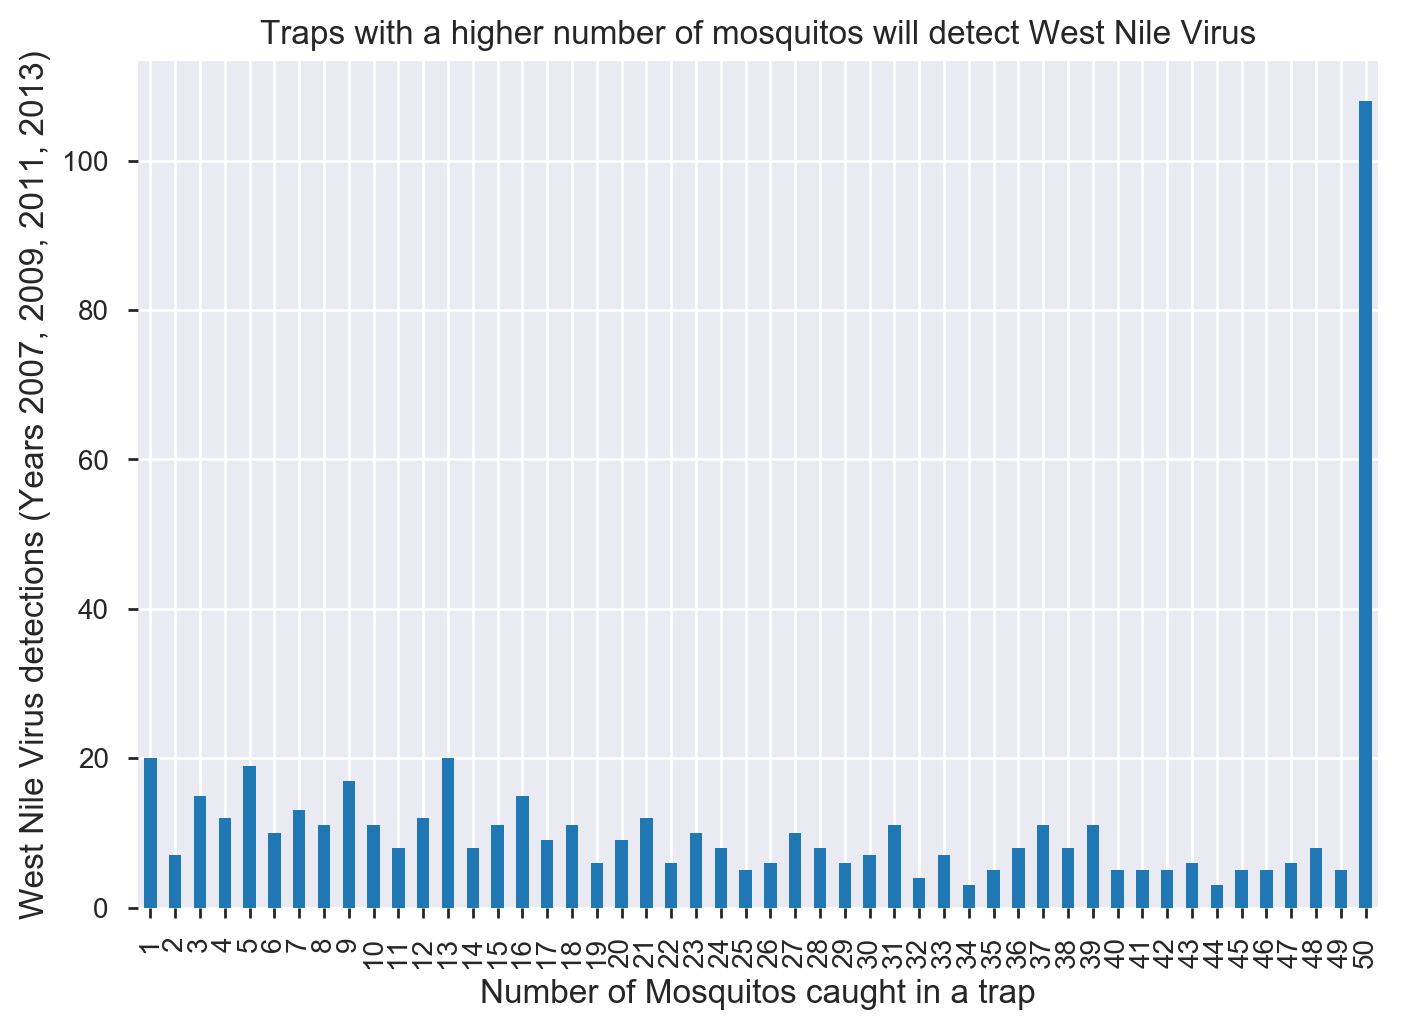

In [58]:
trw.groupby(['NumMosquitos'])['WnvPresent'].sum().plot.bar() 
plt.title("Traps with a higher number of mosquitos will detect West Nile Virus", fontsize='large')
plt.xlabel("Number of Mosquitos caught in a trap", fontsize ='large')
plt.xticks(rotation=90)
plt.ylabel("West Nile Virus detections (Years 2007, 2009, 2011, 2013)", fontsize='large')

Text(0,0.5,'West Nile Virus detections ')

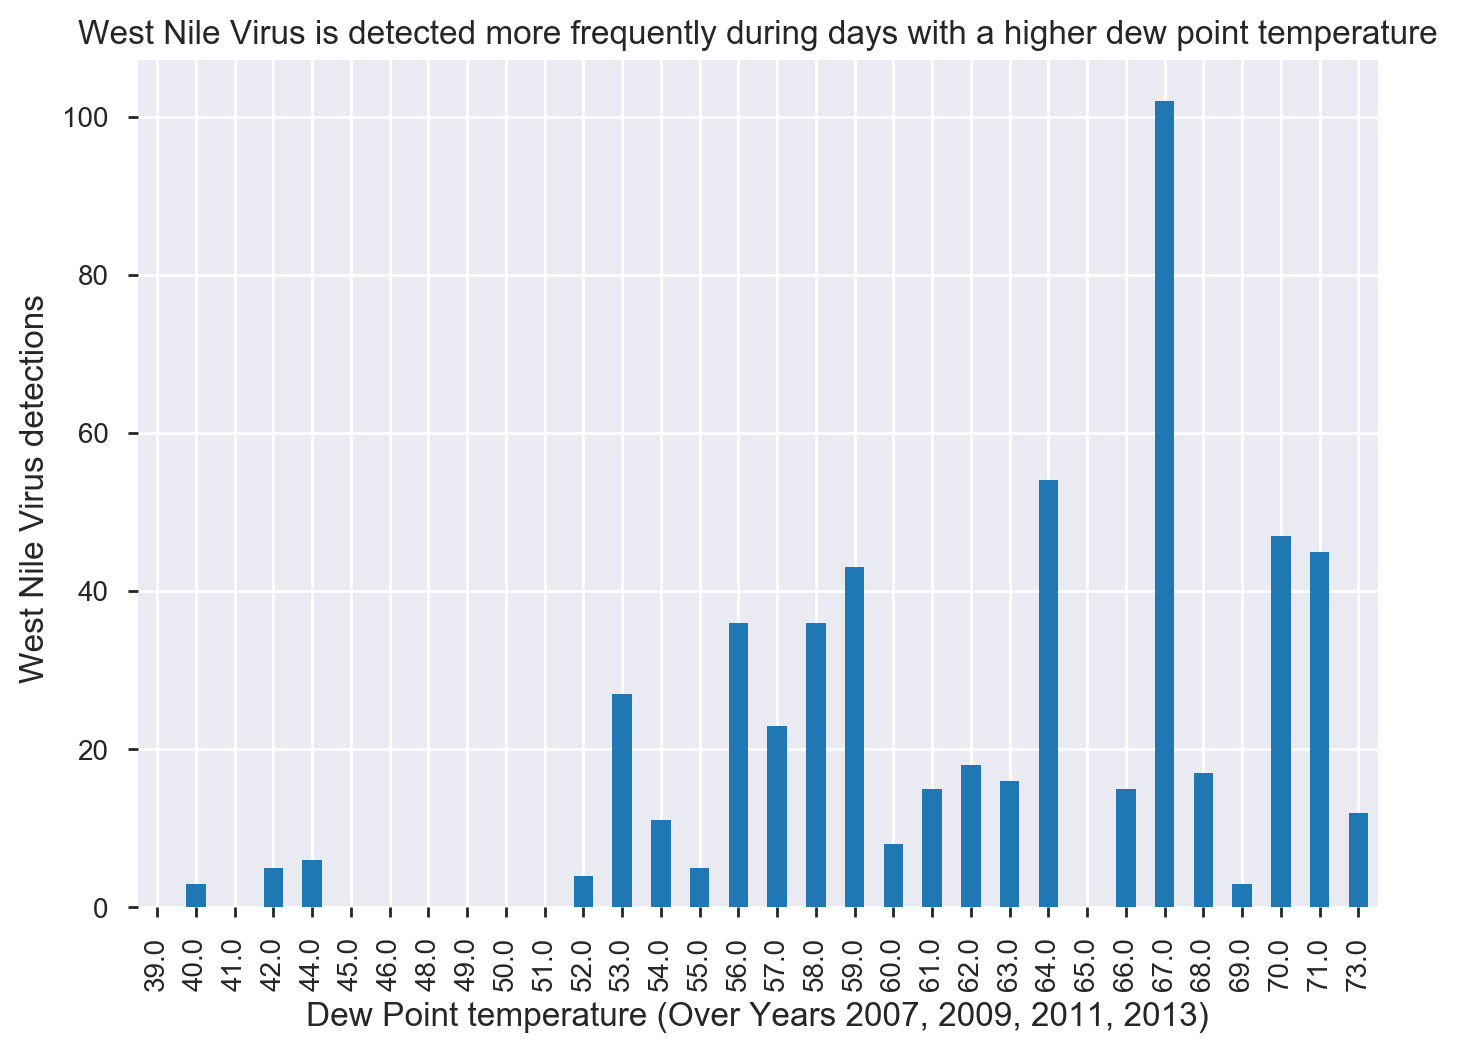

In [59]:
trw.groupby(['DewPoint'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected more frequently during days with a higher dew point temperature", fontsize='large')
plt.xlabel("Dew Point temperature (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.xticks(rotation=90)
plt.ylabel("West Nile Virus detections ", fontsize='large') #what years were observed in the title

Text(0,0.5,'West Nile Virus detections')

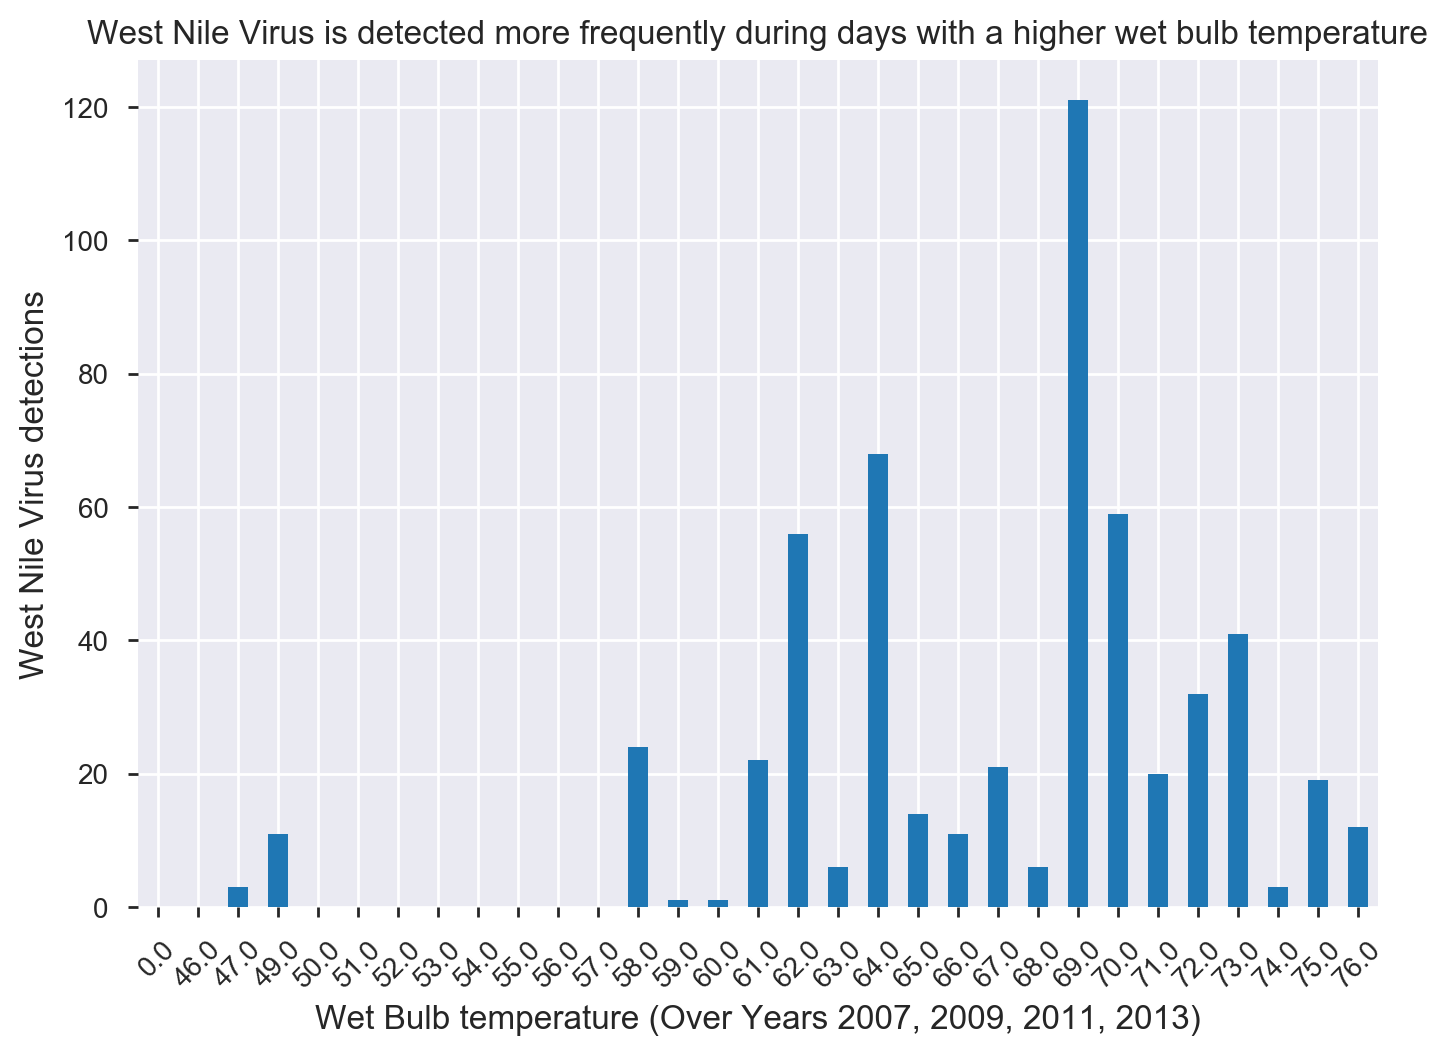

In [60]:
trw.groupby(['WetBulb'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected more frequently during days with a higher wet bulb temperature", fontsize='large')
plt.xlabel("Wet Bulb temperature (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.xticks(rotation=45)
plt.ylabel("West Nile Virus detections", fontsize='large')

Text(0,0.5,'West Nile Virus detections')

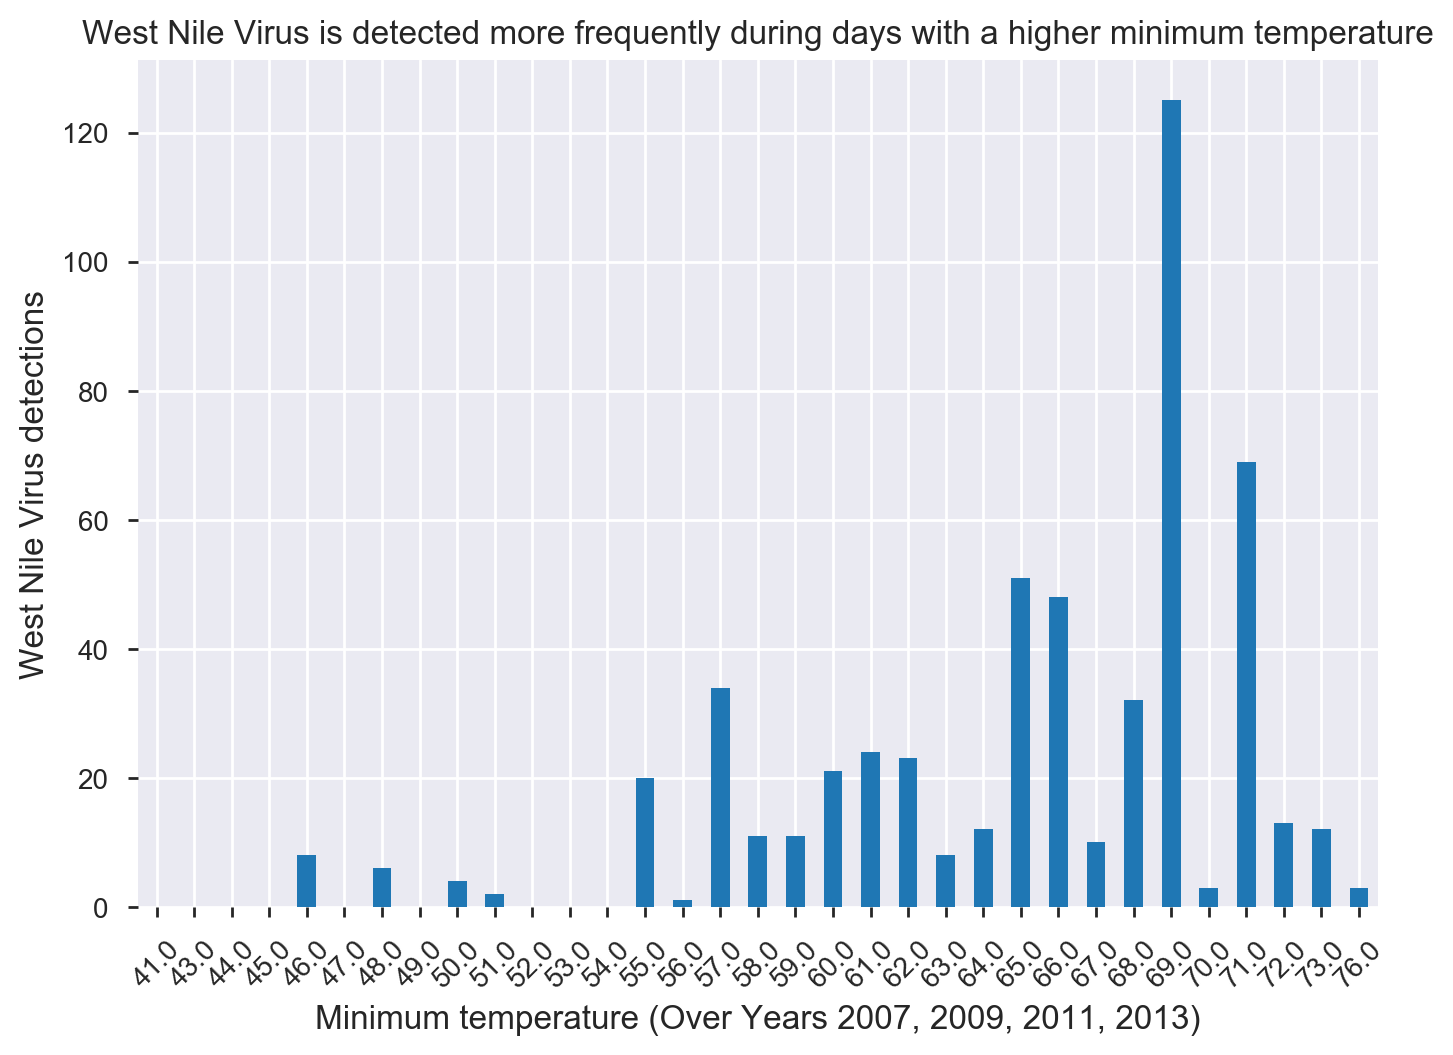

In [61]:
trw.groupby(['Tmin'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected more frequently during days with a higher minimum temperature", fontsize='large')
plt.xlabel("Minimum temperature (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.xticks(rotation=45)
plt.ylabel("West Nile Virus detections", fontsize='large')

Text(0,0.5,'West Nile Virus detections')

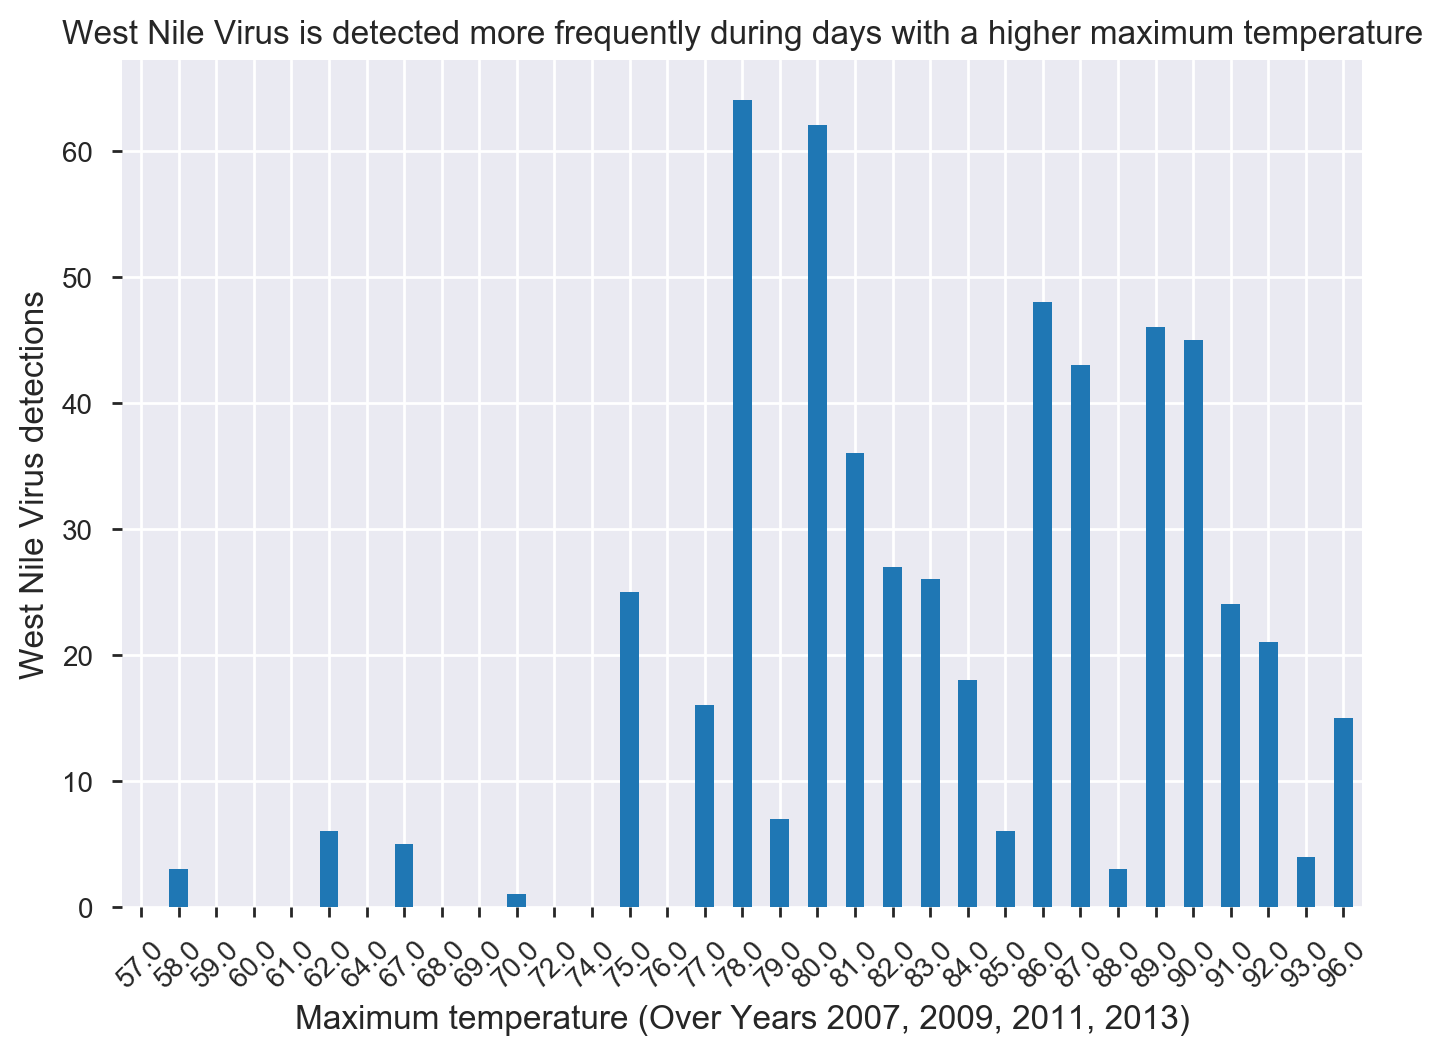

In [62]:
trw.groupby(['Tmax'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected more frequently during days with a higher maximum temperature", fontsize='large')
plt.xlabel("Maximum temperature (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.xticks(rotation=45)
plt.ylabel("West Nile Virus detections", fontsize='large')

Text(0,0.5,'West Nile Virus detections')

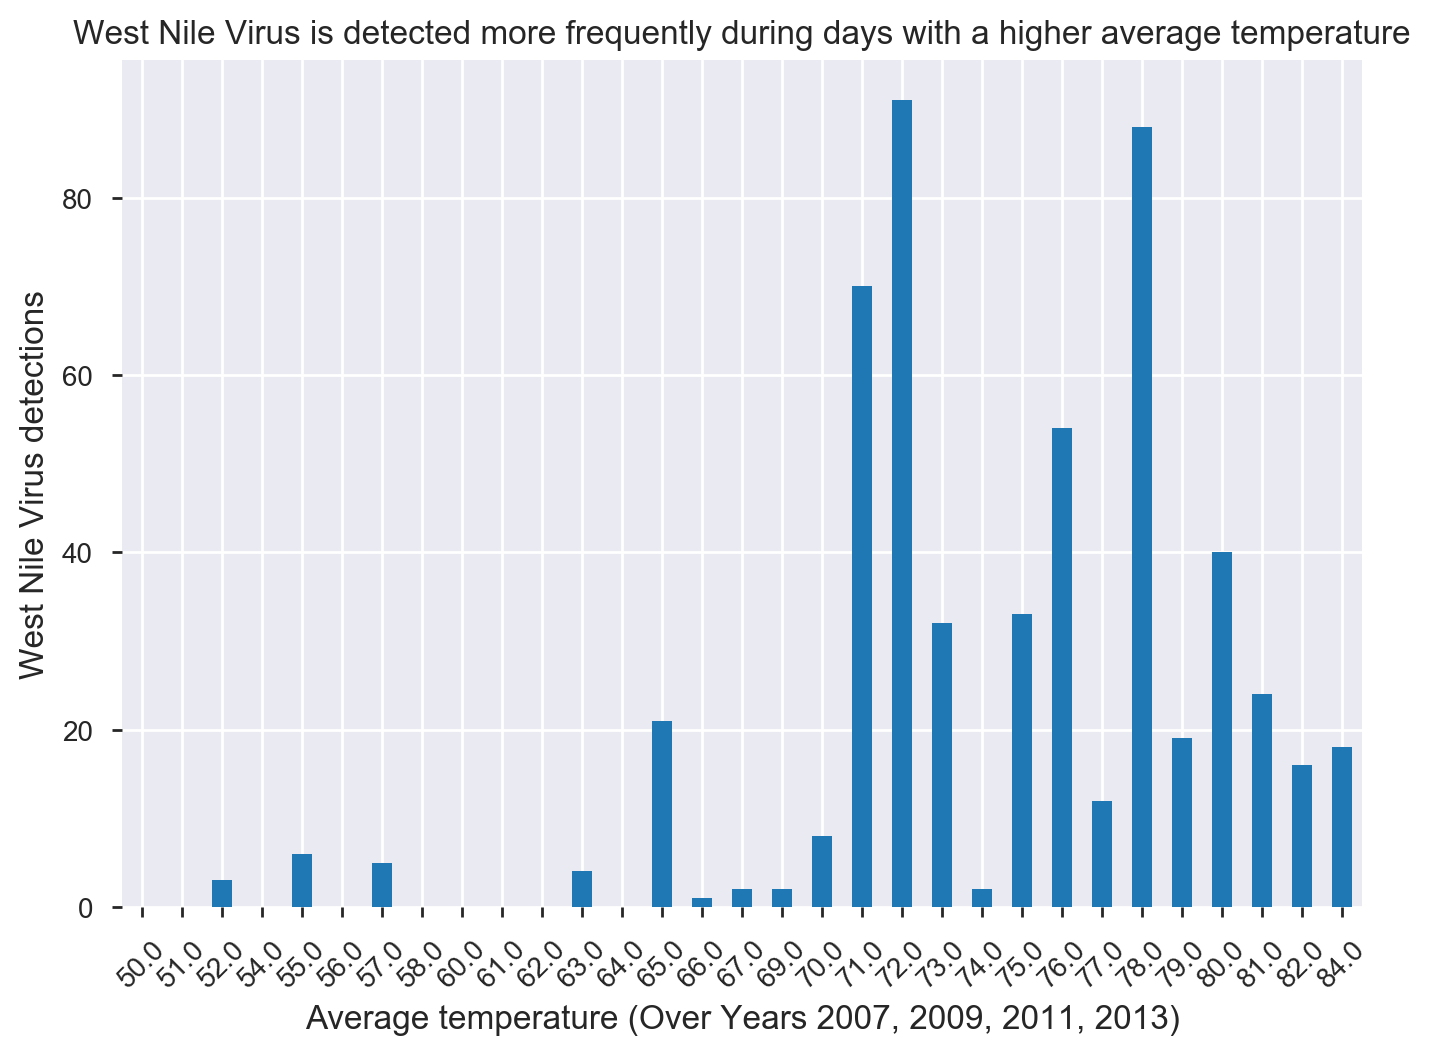

In [63]:
trw.groupby(['Tavg'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected more frequently during days with a higher average temperature", fontsize='large')
plt.xlabel("Average temperature (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.xticks(rotation=45)
plt.ylabel("West Nile Virus detections", fontsize='large')

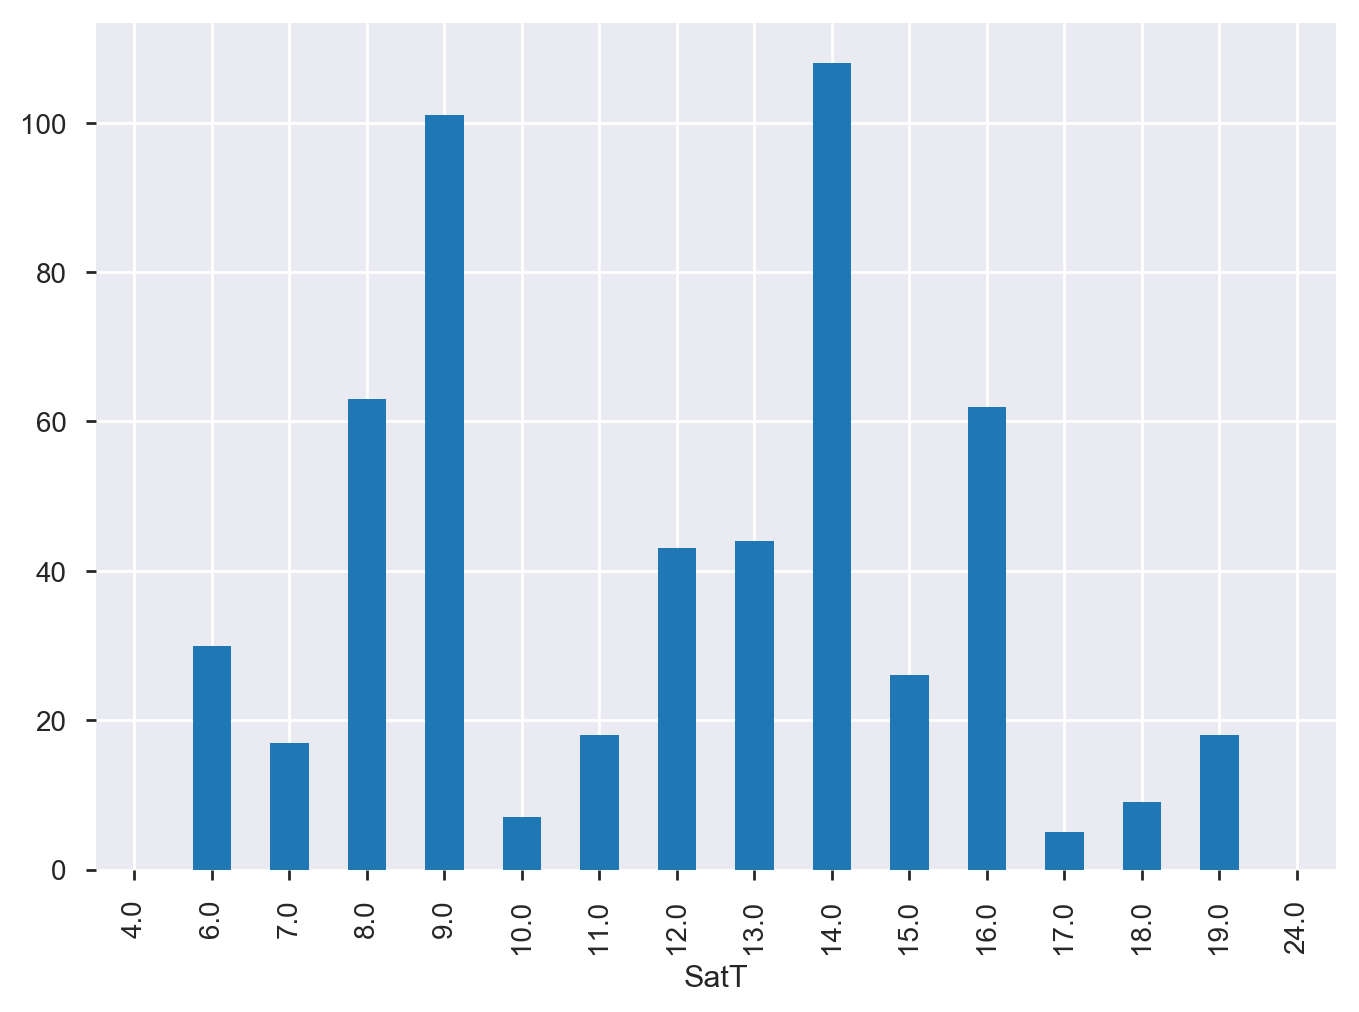

In [64]:
trw.groupby(['SatT'])['WnvPresent'].sum().plot.bar()
#a lot of variation for this feature engineered variable of the difference between the dew point and the air temp

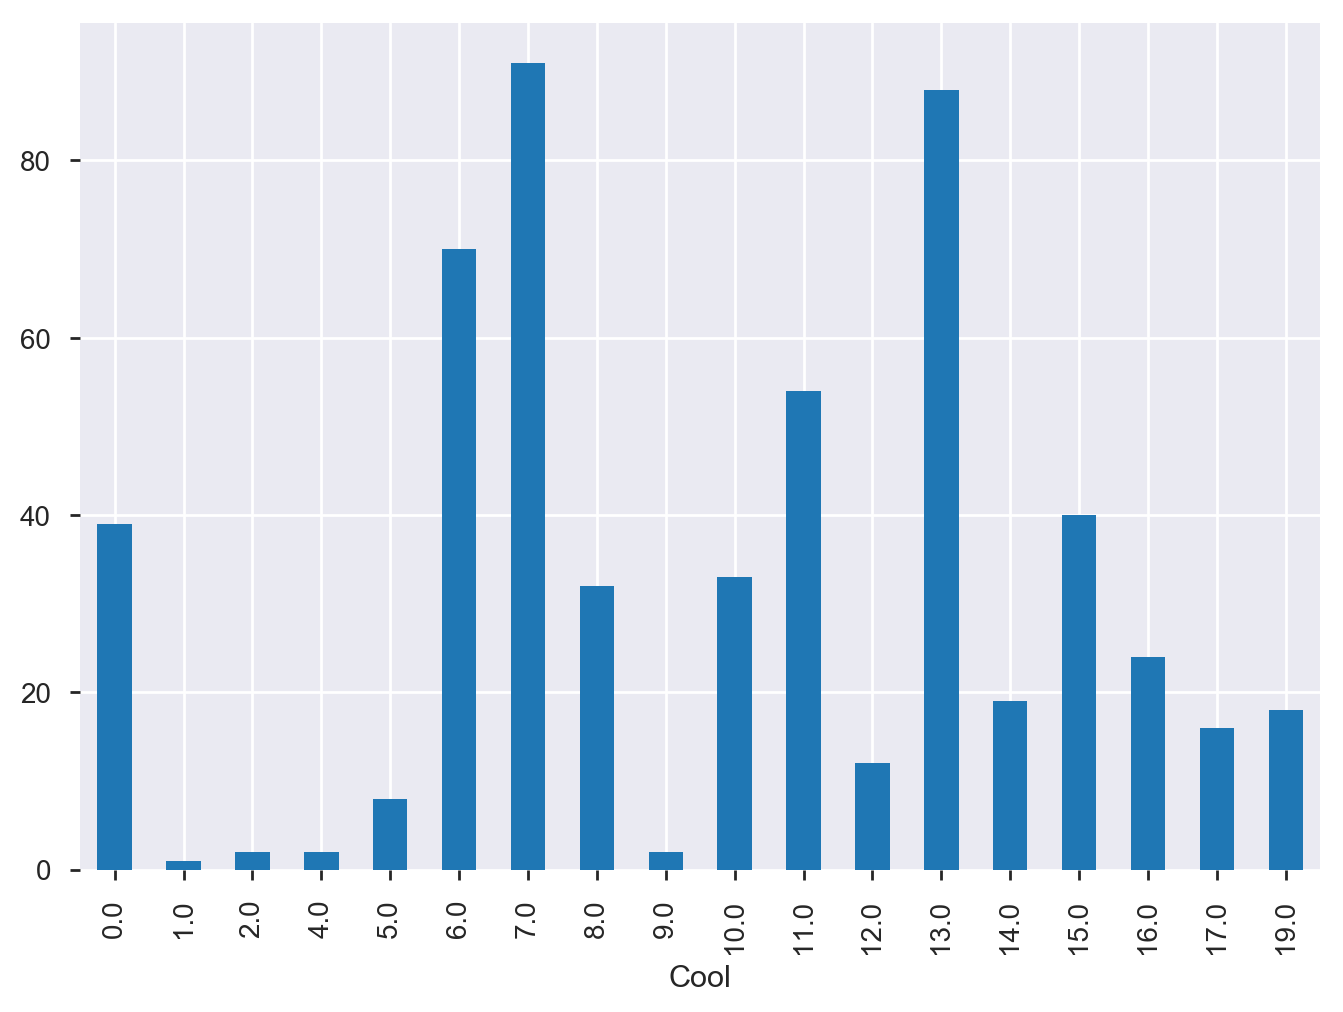

In [65]:
trw.groupby(['Cool'])['WnvPresent'].sum().plot.bar() #probably not the best variable to use here. 

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

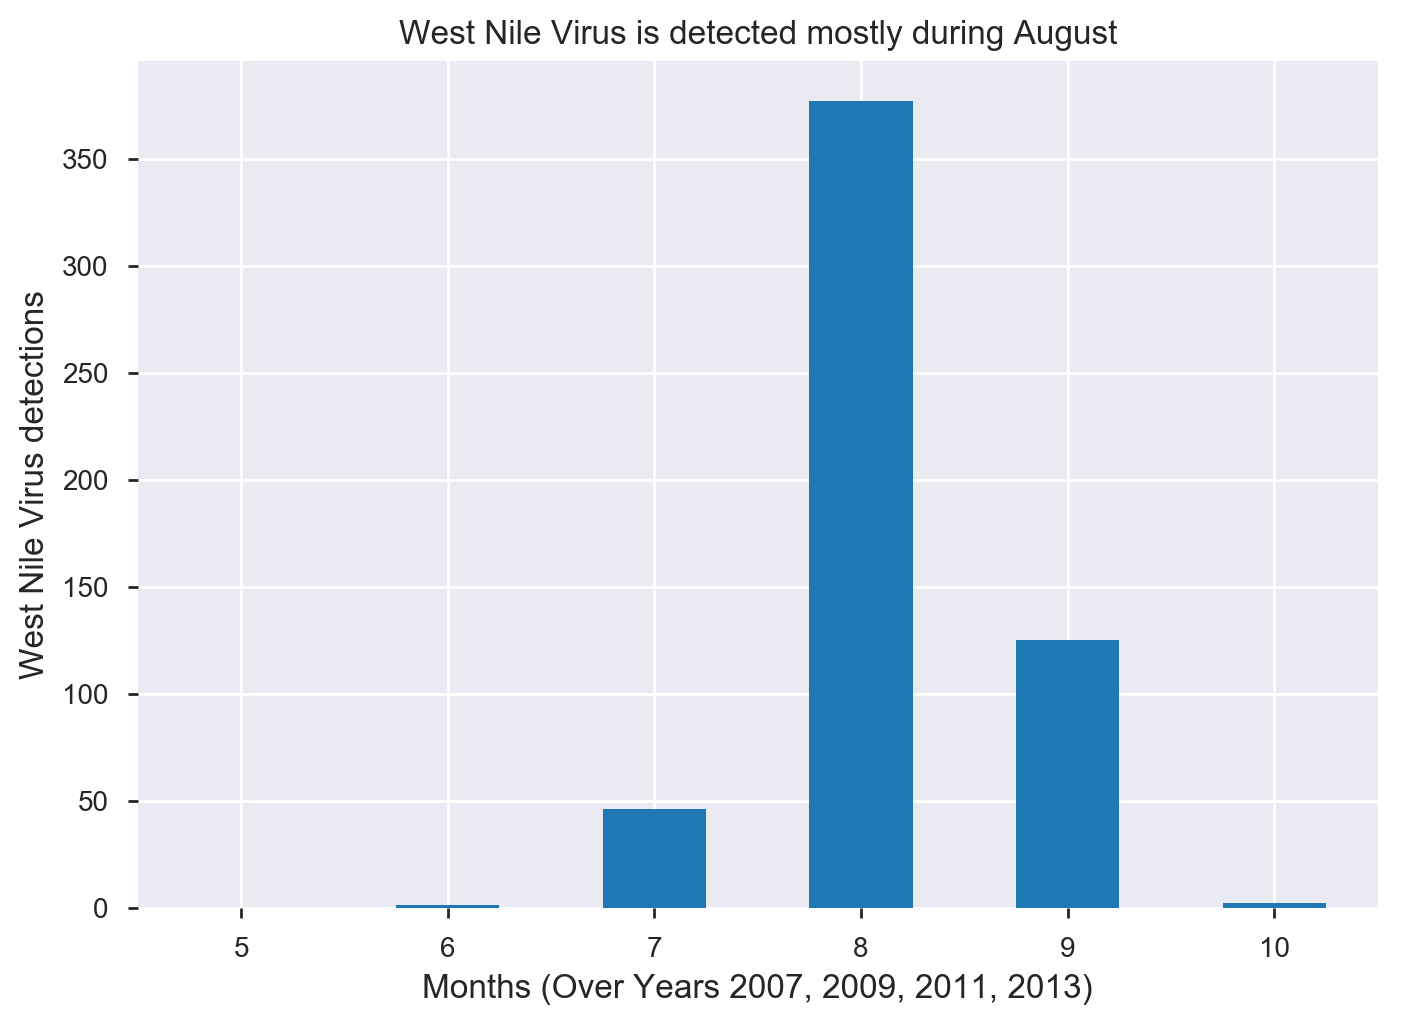

In [91]:
trw.groupby(['Month'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected mostly during August", fontsize='large')
plt.xlabel("Months (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("West Nile Virus detections", fontsize='large')
plt.xticks(rotation=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

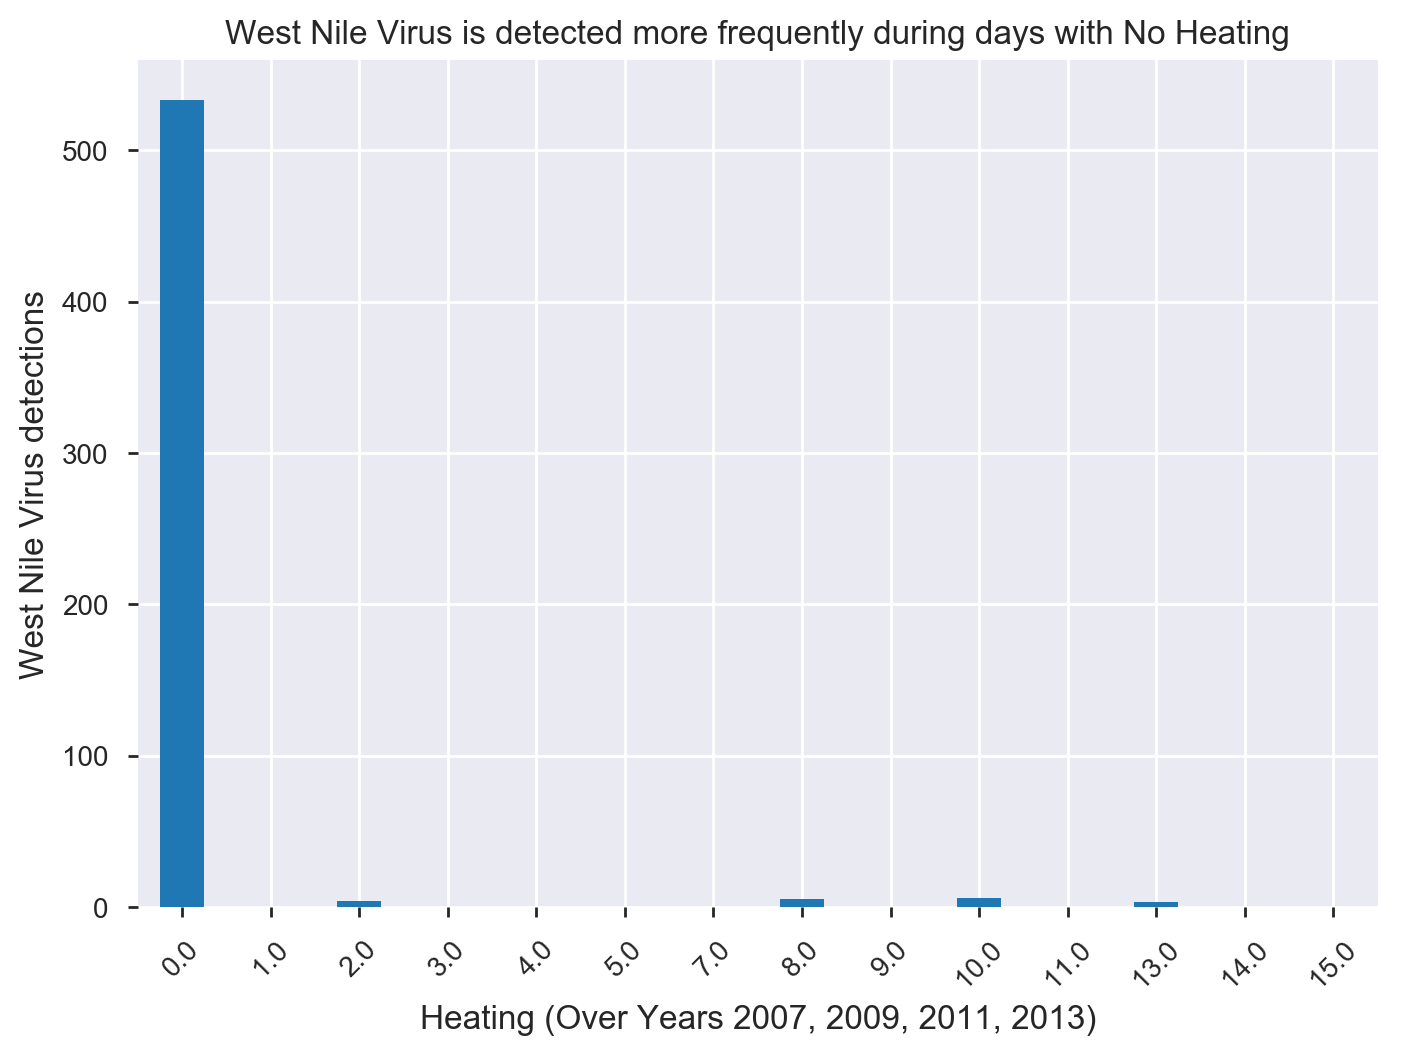

In [66]:
trw.groupby(['Heat'])['WnvPresent'].sum().plot.bar()
plt.title("West Nile Virus is detected more frequently during days with No Heating", fontsize='large')
plt.xlabel("Heating (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("West Nile Virus detections", fontsize='large')
plt.xticks(rotation=45)

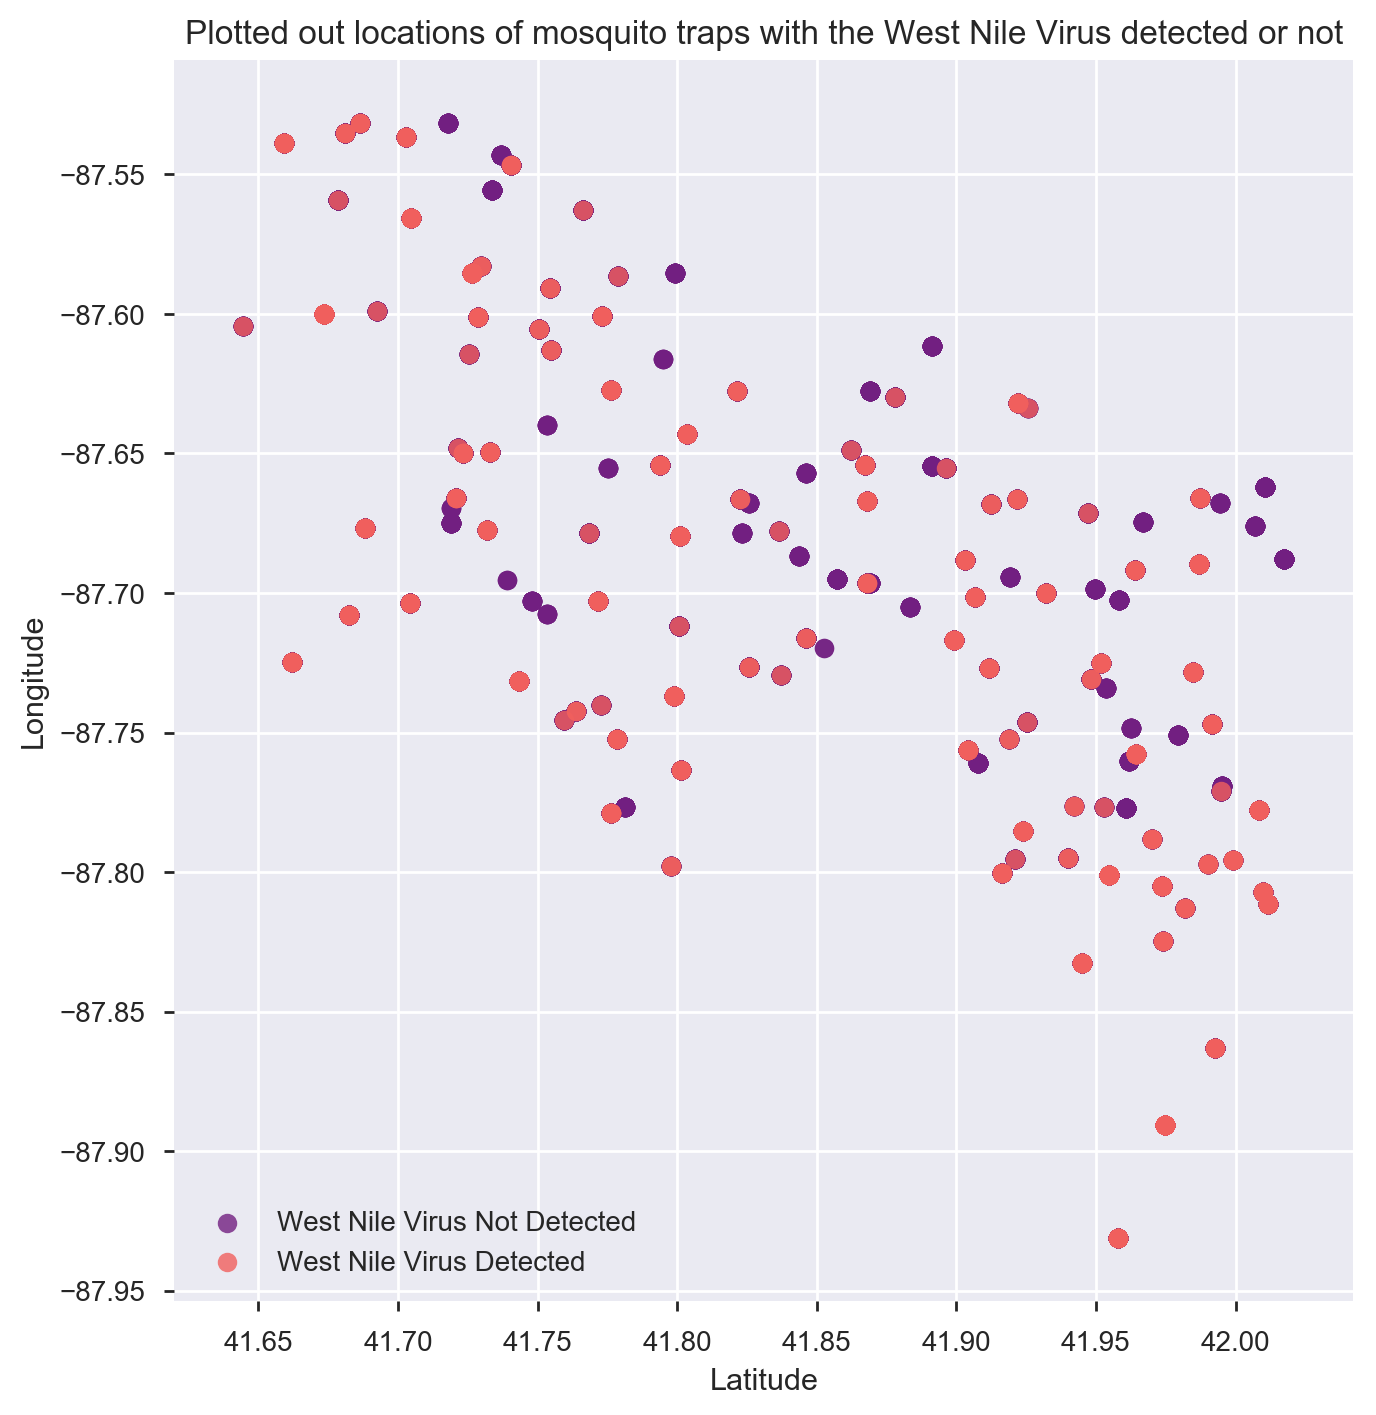

In [67]:
sns.lmplot( x='Latitude', y='Longitude', data=trw, fit_reg=False, hue='WnvPresent', palette='magma', size=7, legend=False)
plt.title('Plotted out locations of mosquito traps with the West Nile Virus detected or not')
L=plt.legend(loc='lower left')
L.get_texts()[0].set_text('West Nile Virus Not Detected')
L.get_texts()[1].set_text('West Nile Virus Detected')

Text(13.3194,0.5,'Maximum Temperature')

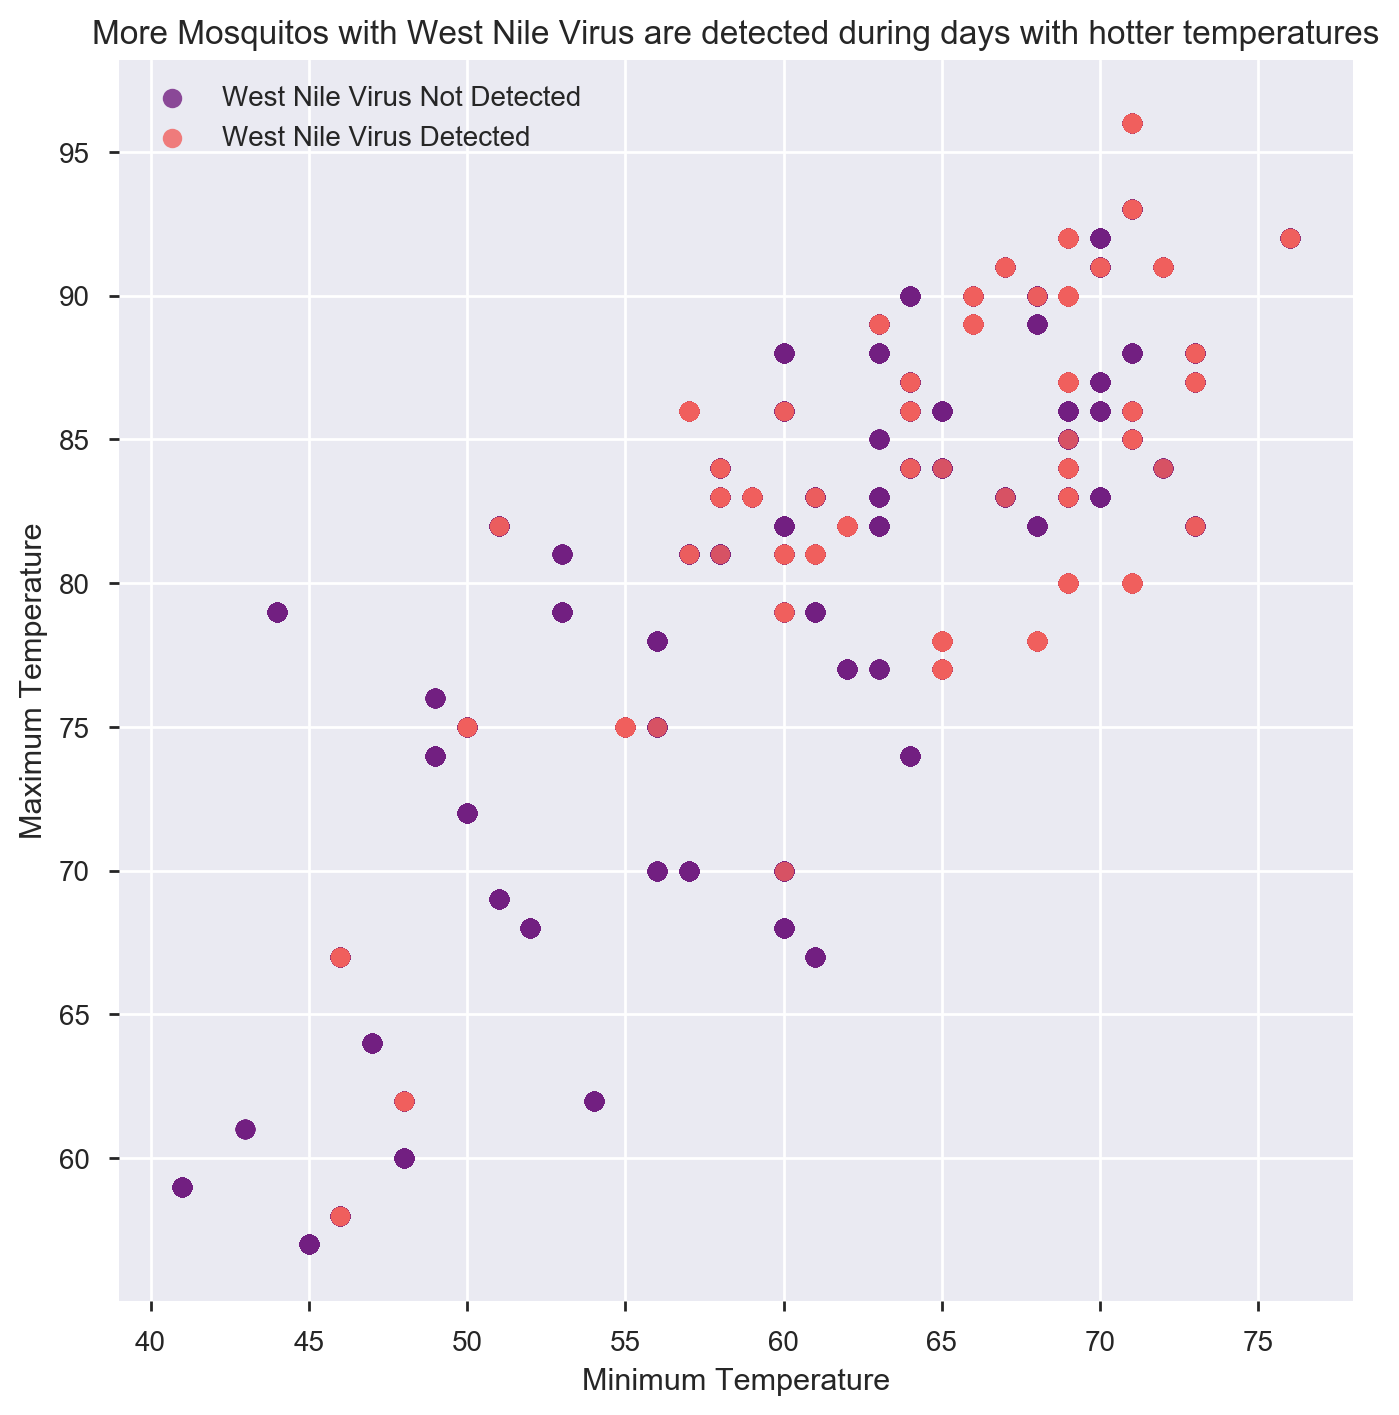

In [68]:
sns.lmplot( x='Tmin', y='Tmax', data=trw, fit_reg=False, hue='WnvPresent', palette='magma', size=7, legend=False)
L=plt.legend(loc='upper left')
L.get_texts()[0].set_text('West Nile Virus Not Detected')
L.get_texts()[1].set_text('West Nile Virus Detected')
plt.title('More Mosquitos with West Nile Virus are detected during days with hotter temperatures')
plt.xlabel('Minimum Temperature')
plt.ylabel('Maximum Temperature')

Text(13.3194,0.5,'Dew Point Temperature')

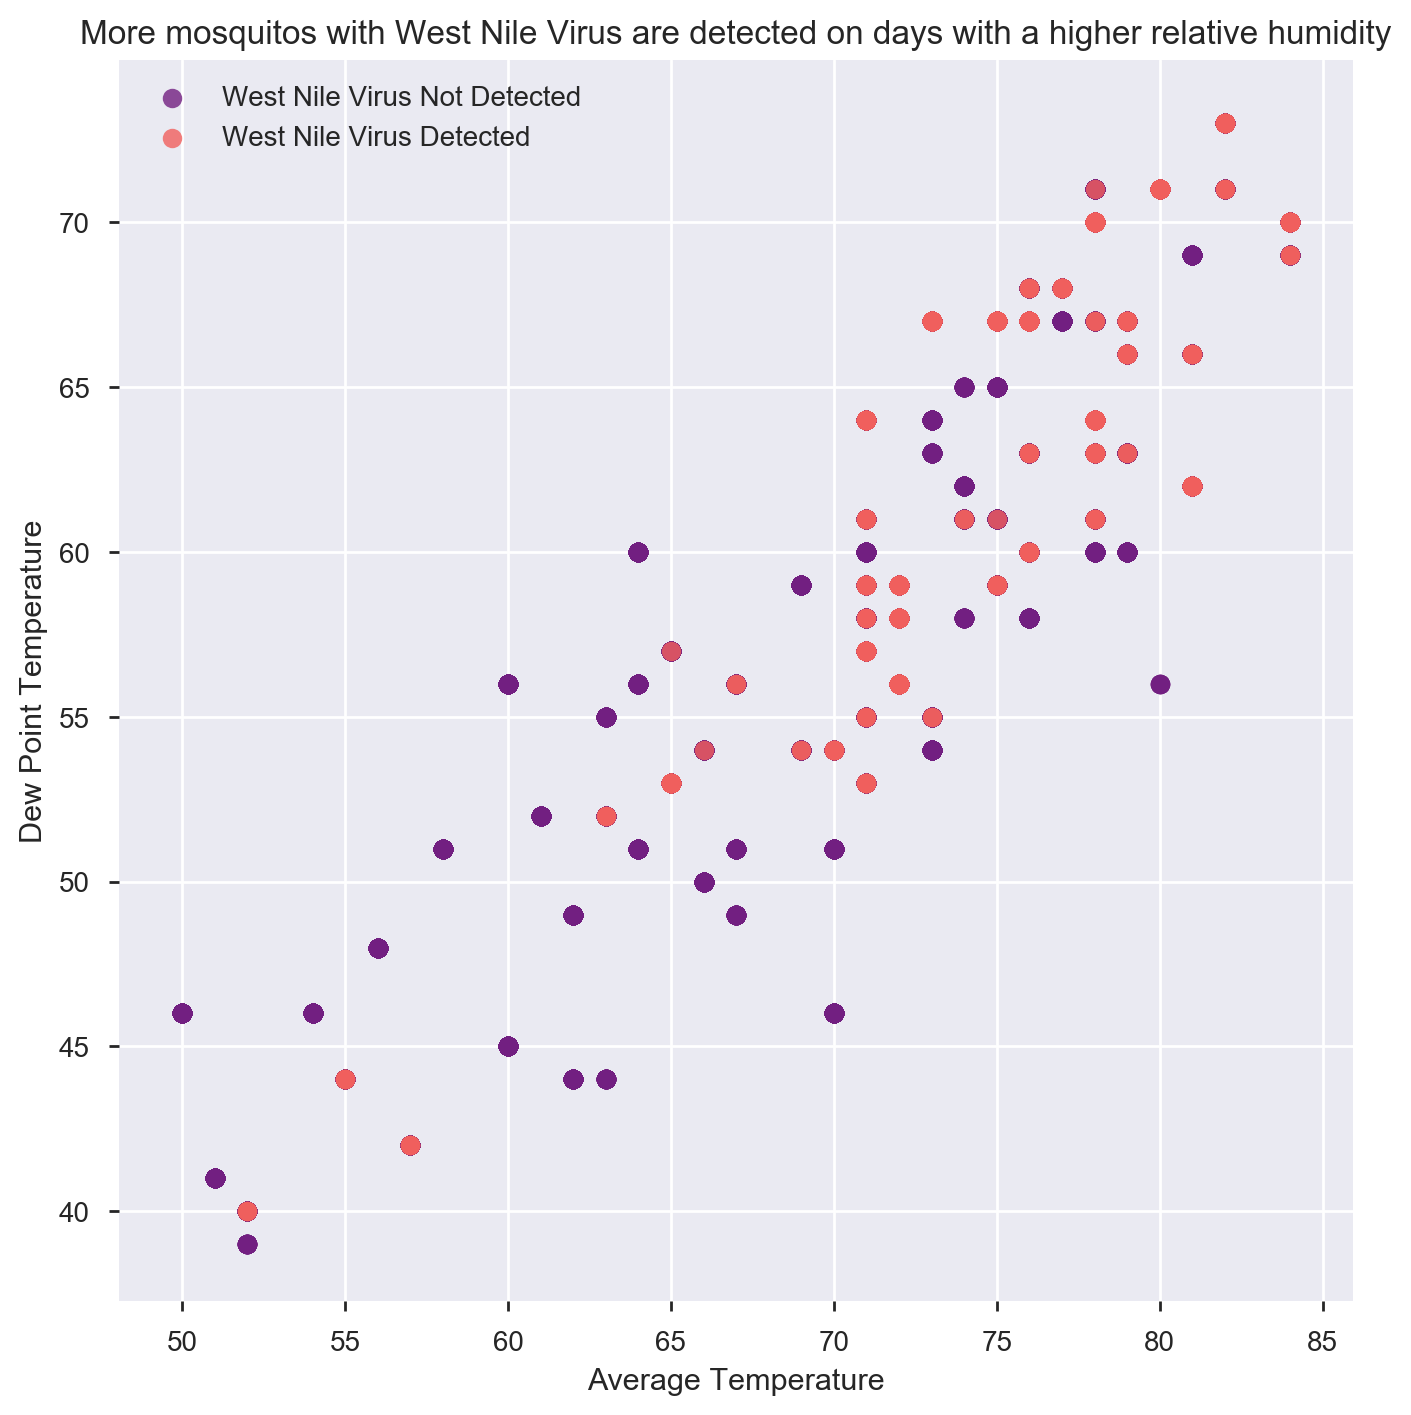

In [105]:
sns.lmplot( x='Tavg', y='DewPoint', data=trw, fit_reg=False, hue='WnvPresent', palette='magma', size=7, legend=False)
L=plt.legend(loc='upper left')
L.get_texts()[0].set_text('West Nile Virus Not Detected')
L.get_texts()[1].set_text('West Nile Virus Detected')
plt.title('More mosquitos with West Nile Virus are detected on days with a higher relative humidity')
plt.xlabel('Average Temperature')
plt.ylabel('Dew Point Temperature')

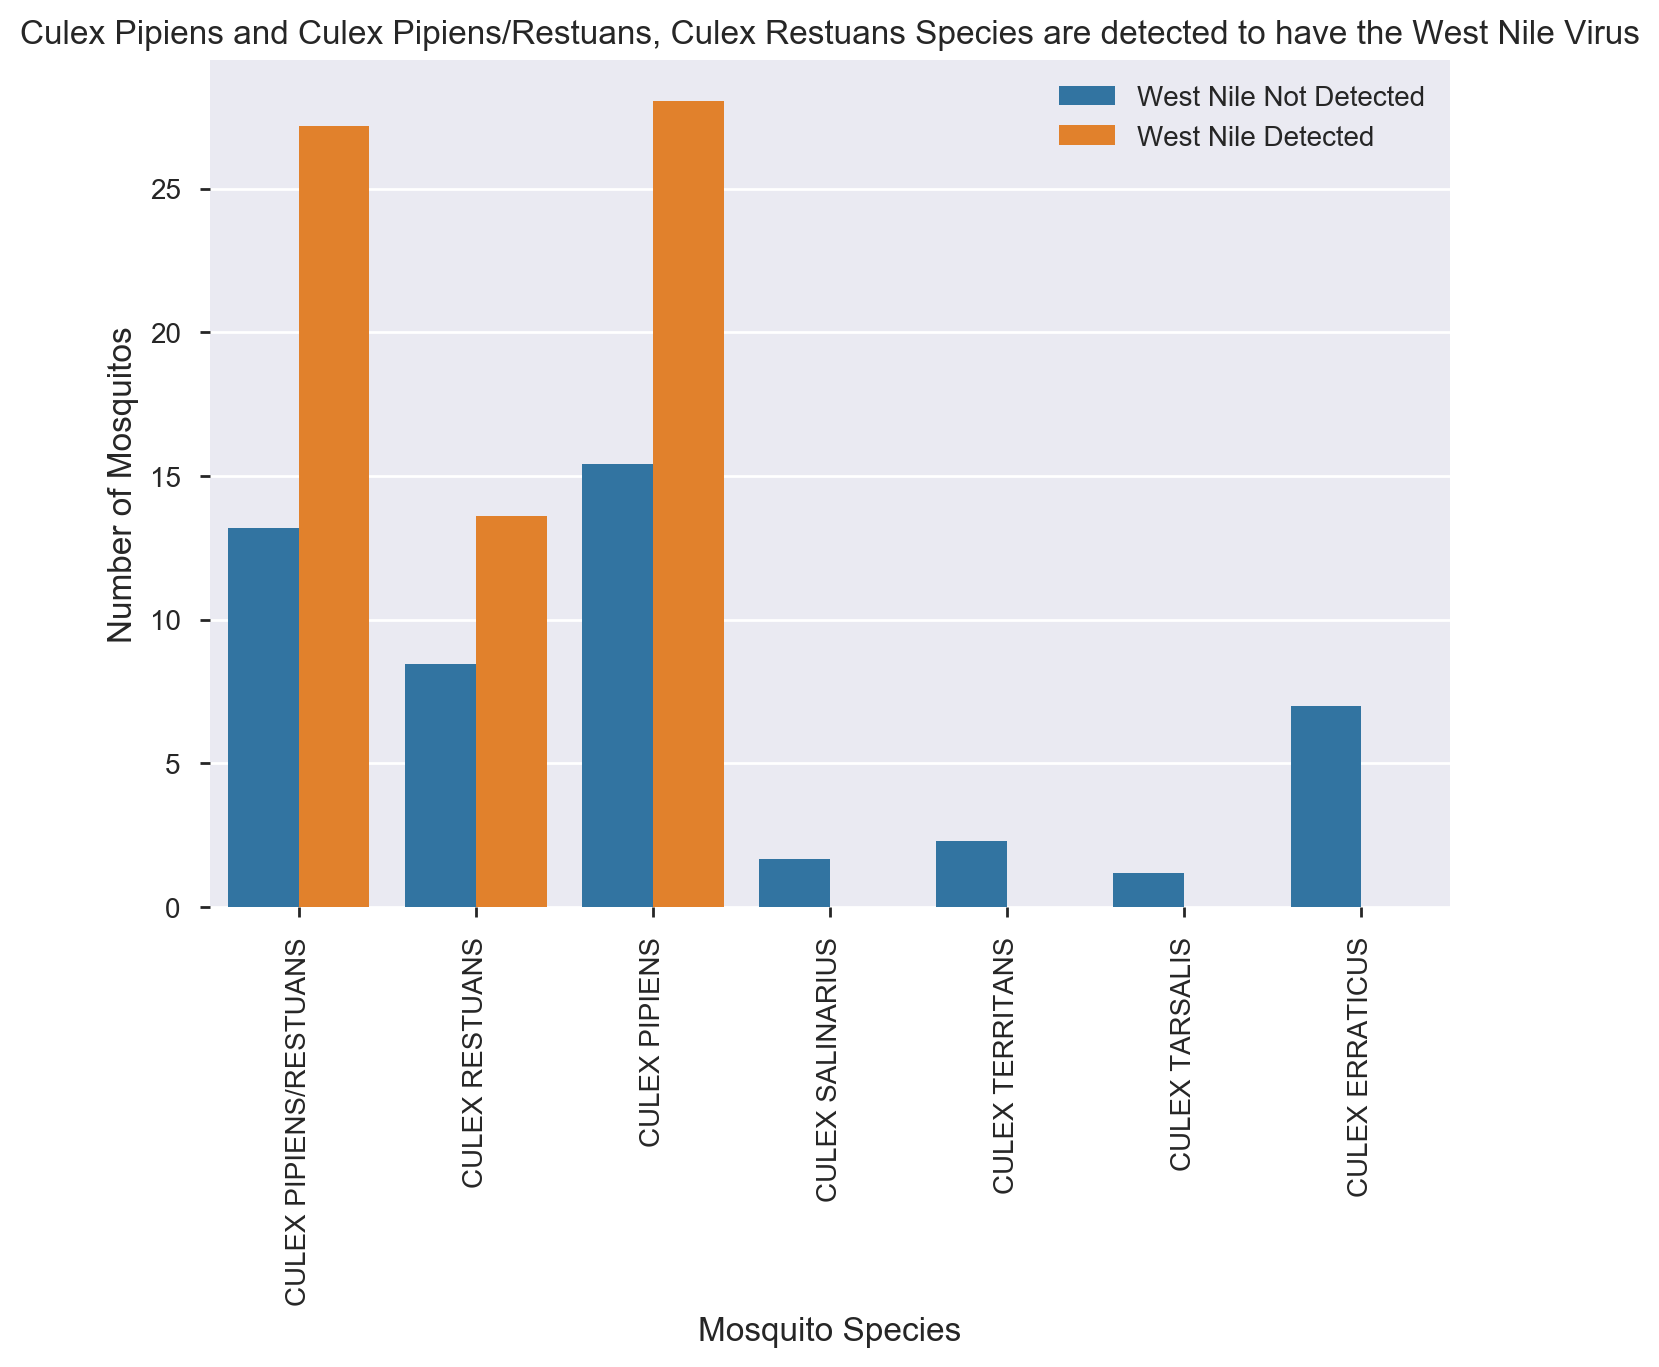

In [70]:
sns.barplot(x='Species', y='NumMosquitos', data=trw, hue='WnvPresent', ci=False)
plt.title("Culex Pipiens and Culex Pipiens/Restuans, Culex Restuans Species are detected to have the West Nile Virus", fontsize='large')
plt.xlabel("Mosquito Species", fontsize ='large')
plt.ylabel("Number of Mosquitos", fontsize='large')
plt.xticks(rotation=90)
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

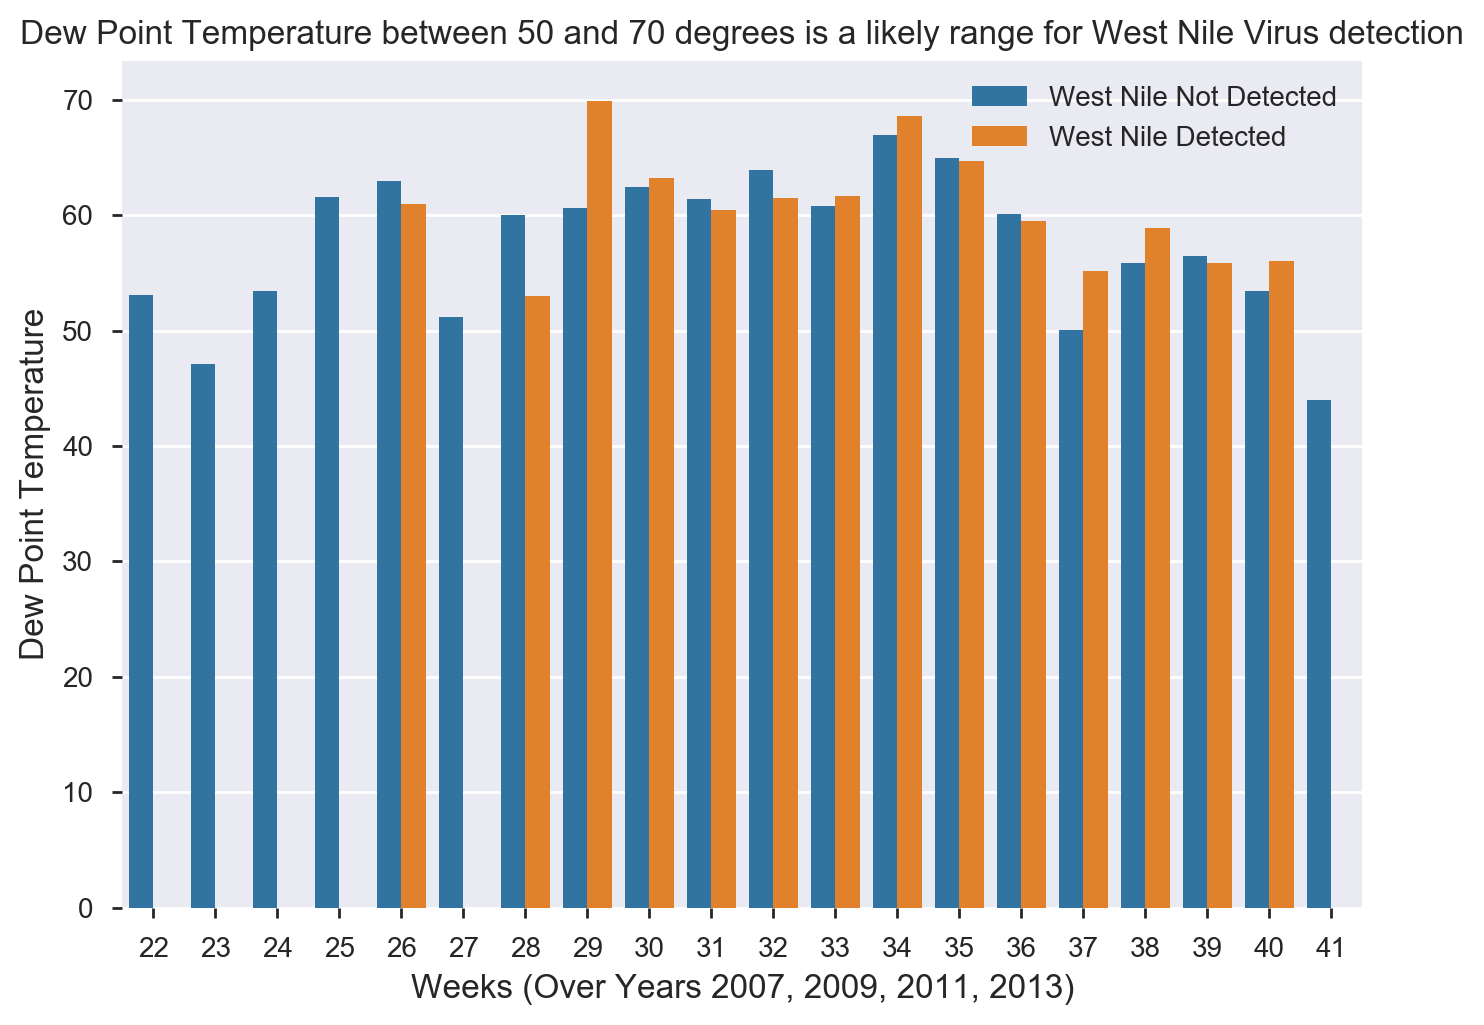

In [71]:
sns.barplot(x='Weeks', y='DewPoint', data=trw, hue='WnvPresent', ci=False)
plt.title("Dew Point Temperature between 50 and 70 degrees is a likely range for West Nile Virus detection", fontsize='large')
plt.xlabel("Weeks (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("Dew Point Temperature", fontsize='large')
plt.xticks(rotation=0)
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

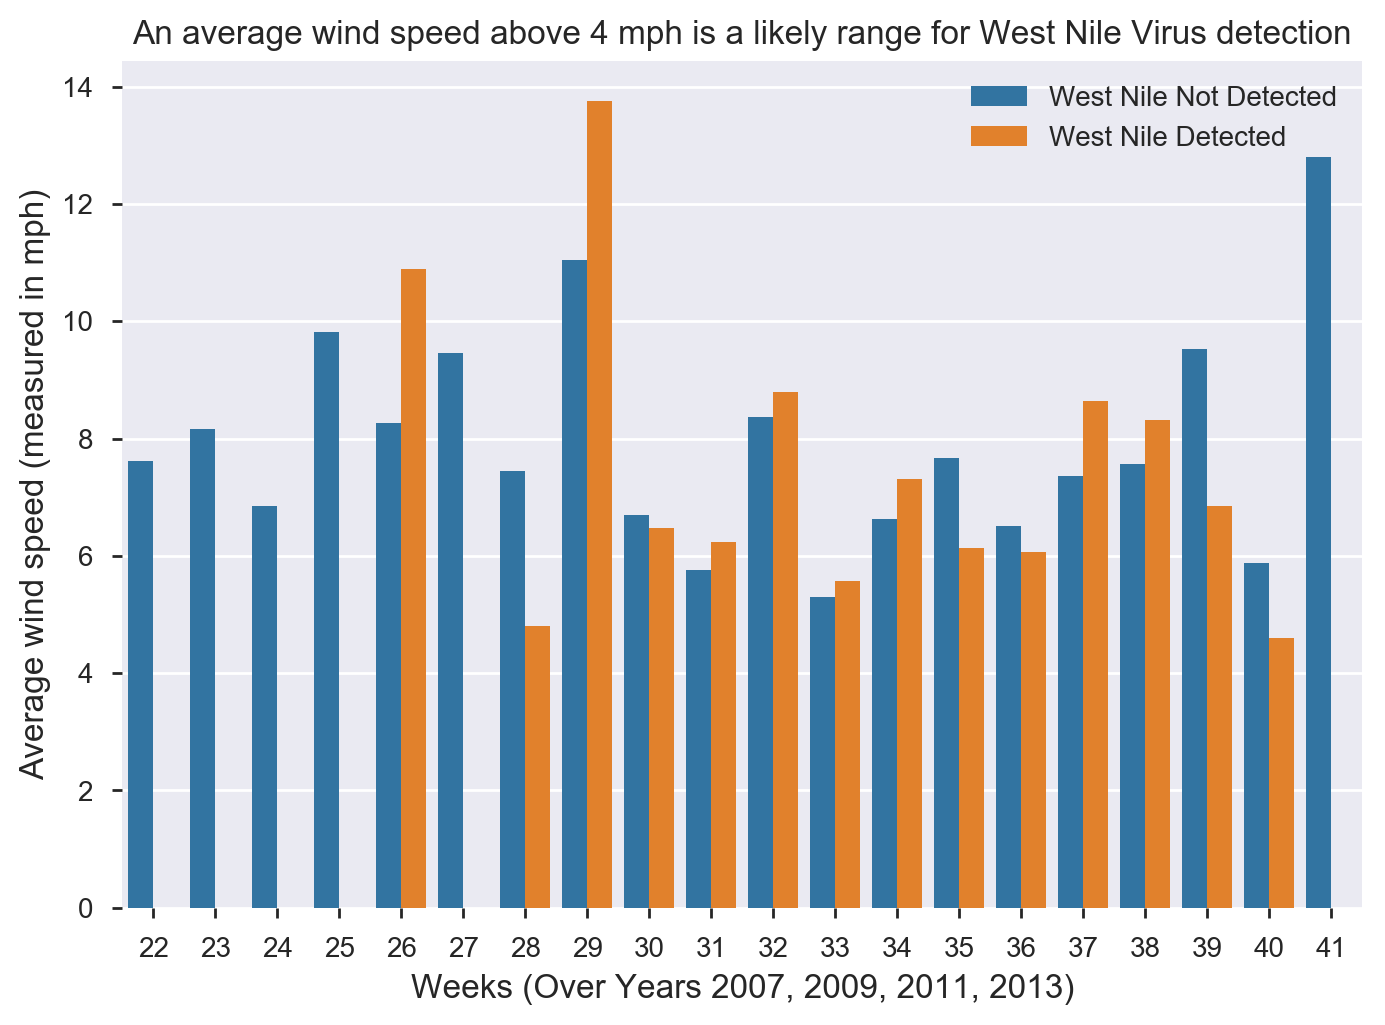

In [72]:
sns.barplot(x='Weeks', y='AvgSpeed', data=trw, hue='WnvPresent', ci=False)
plt.title("An average wind speed above 4 mph is a likely range for West Nile Virus detection", fontsize='large')
plt.xlabel("Weeks (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("Average wind speed (measured in mph)", fontsize='large')
plt.xticks(rotation=0)
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

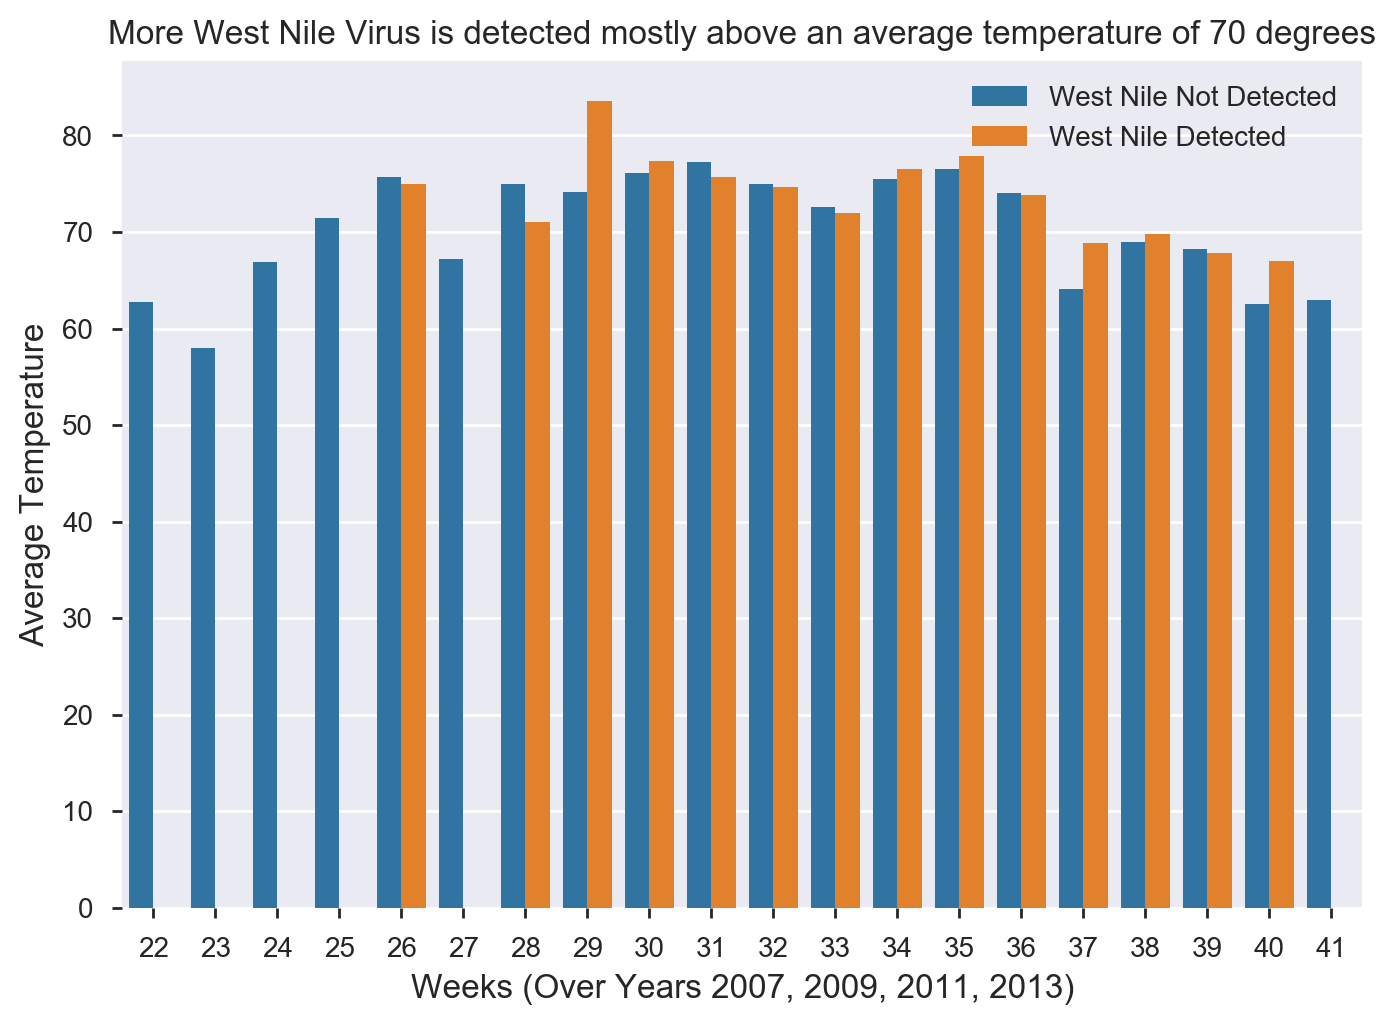

In [73]:
sns.barplot(x='Weeks', y='Tavg', data=trw, hue='WnvPresent', ci=False)
plt.title("More West Nile Virus is detected mostly above an average temperature of 70 degrees", fontsize='large')
plt.xlabel("Weeks (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("Average Temperature", fontsize='large')
plt.xticks(rotation=0)
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

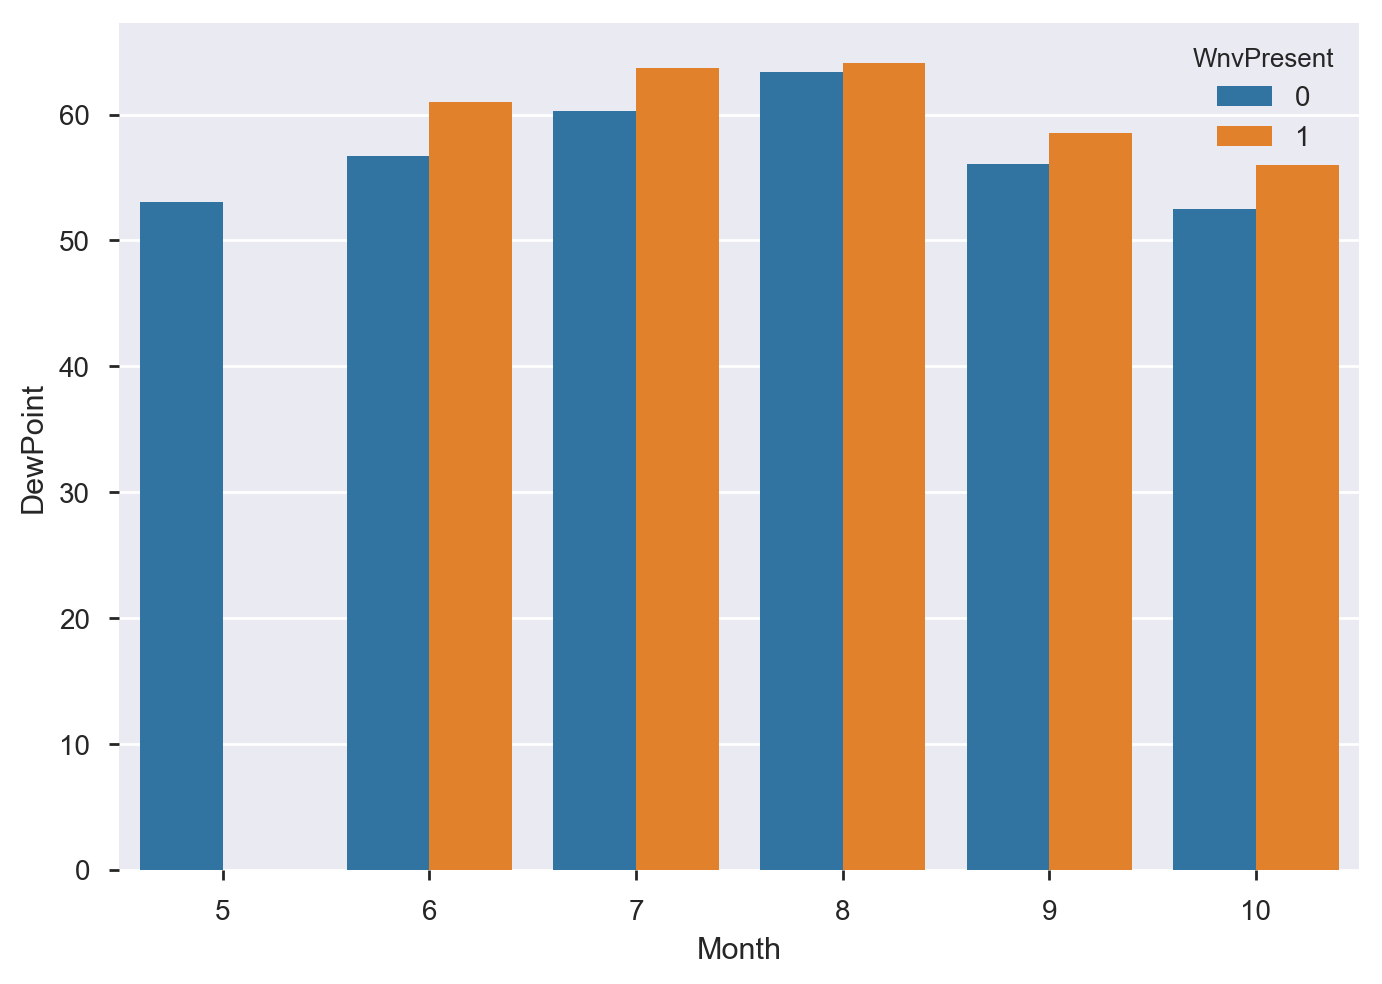

In [74]:
sns.barplot(x='Month', y='DewPoint', data=trw, hue='WnvPresent', ci=False) #doesn't tell me much it tells me 
#the virus is detected almost across all months. 

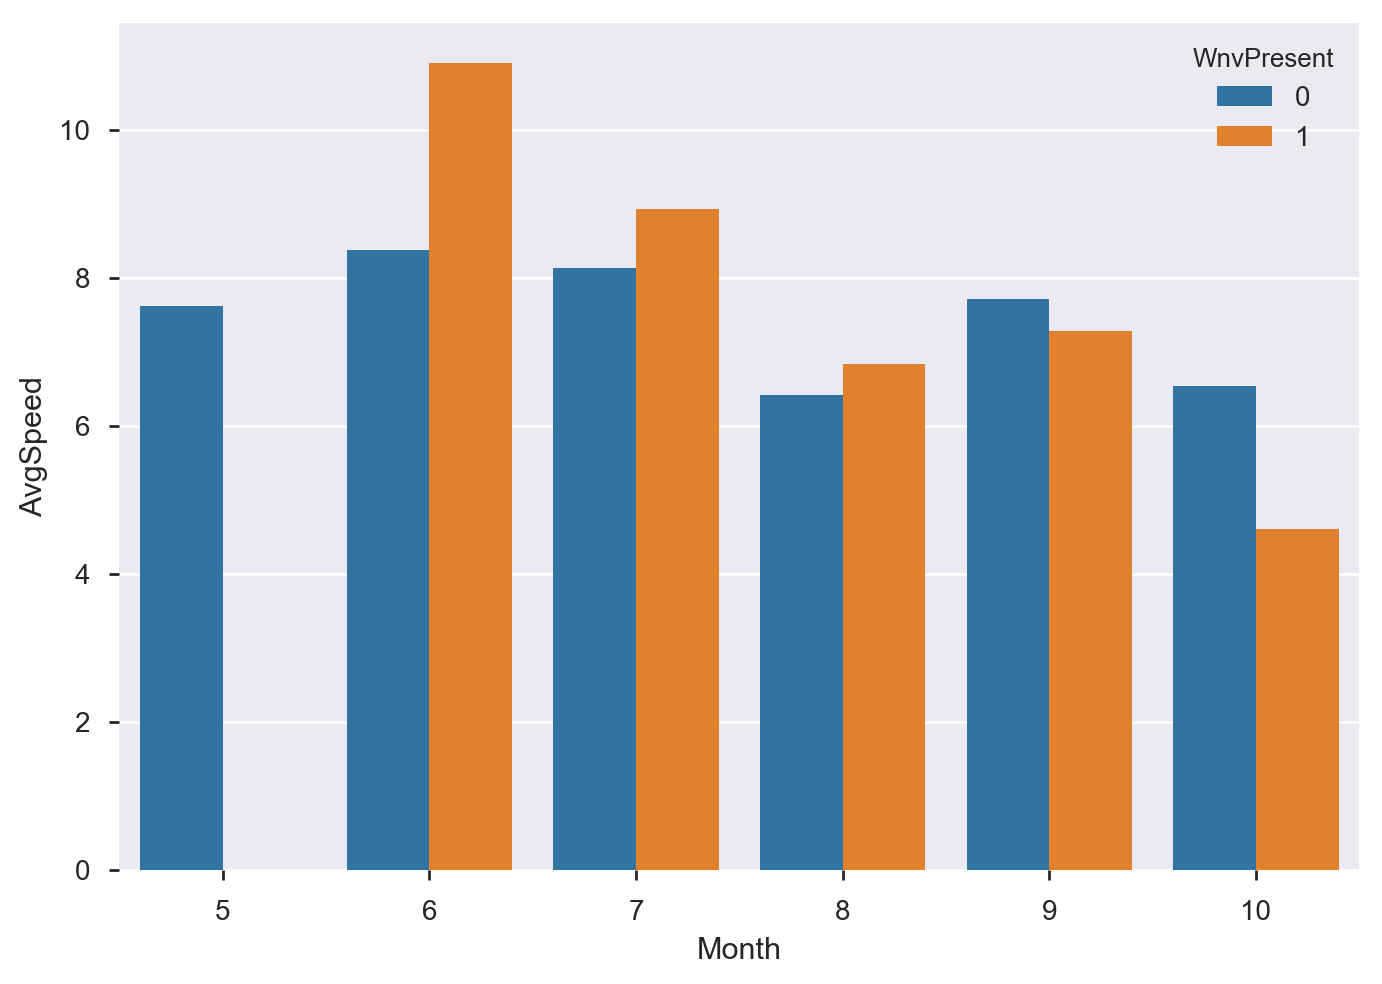

In [75]:
sns.barplot(x='Month', y='AvgSpeed', data=trw, hue='WnvPresent', ci=False) #same conclusion with the previous bar plot

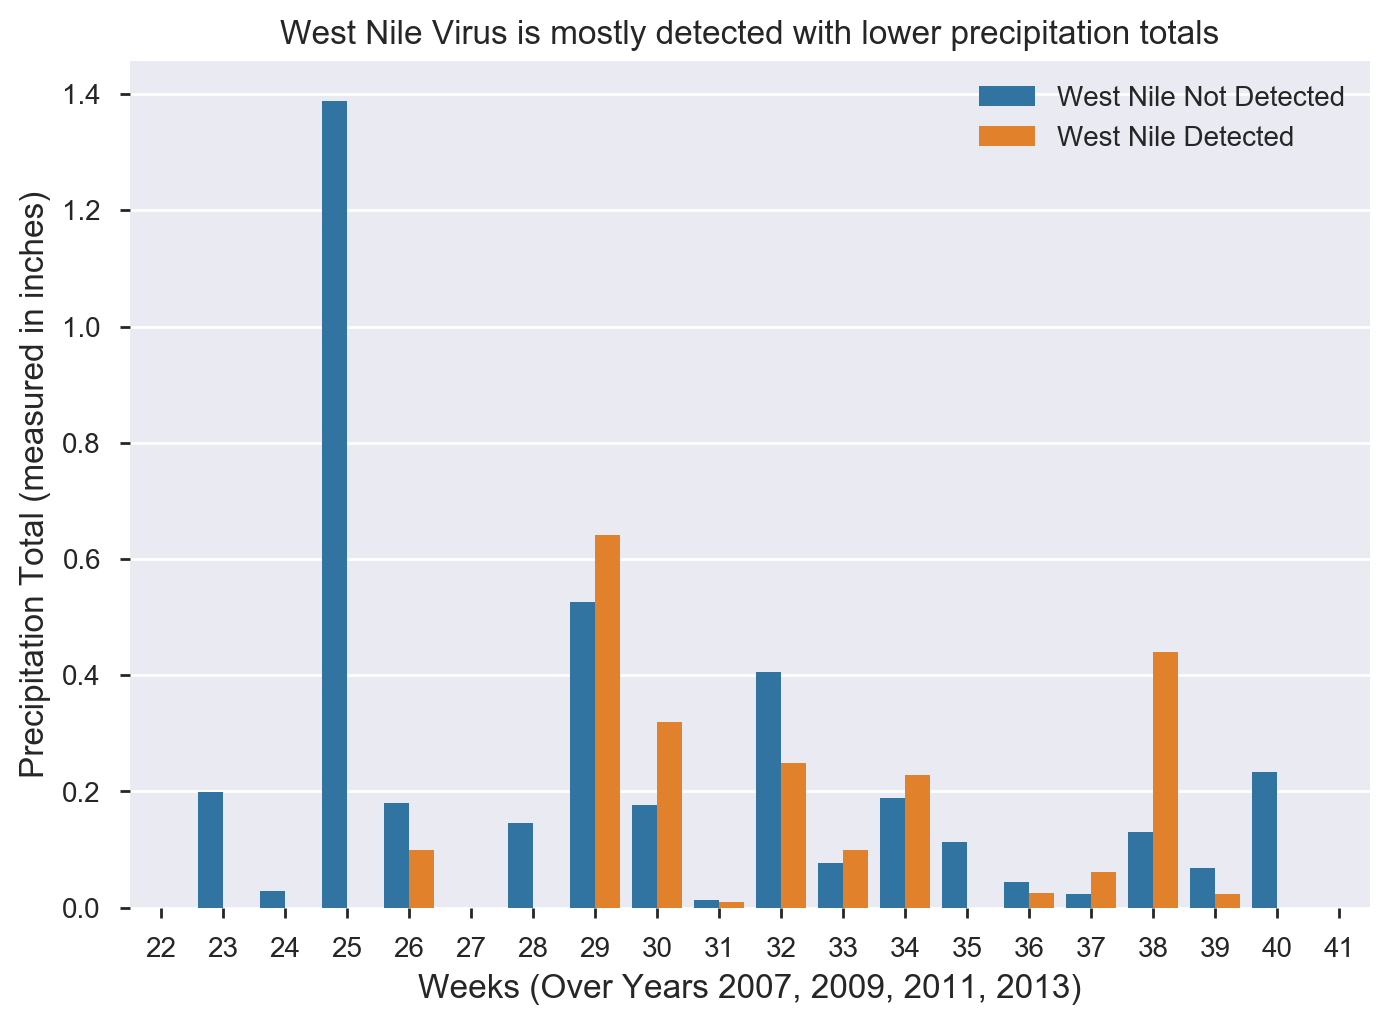

In [76]:
sns.barplot(x='Weeks', y='PrecipTotal', data=trw, hue='WnvPresent', ci=False)
plt.title("West Nile Virus is mostly detected with lower precipitation totals", fontsize='large')
plt.xlabel("Weeks (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("Precipitation Total (measured in inches)", fontsize='large')
plt.xticks(rotation=0)
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

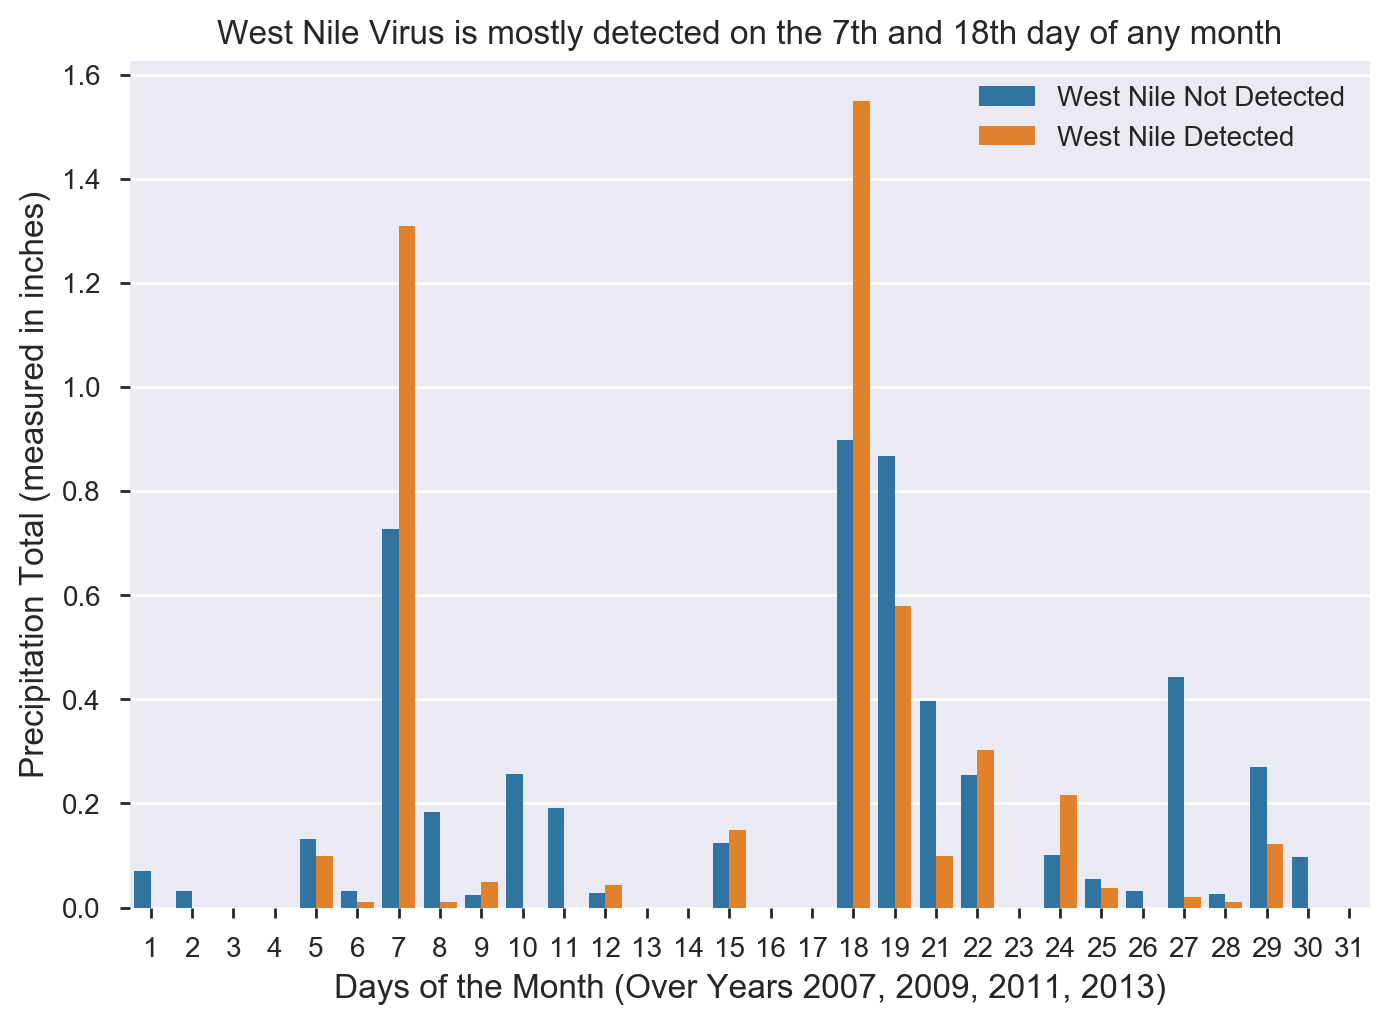

In [77]:
sns.barplot(x='Day', y='PrecipTotal', data=trw, hue='WnvPresent', ci=False)
plt.title("West Nile Virus is mostly detected on the 7th and 18th day of any month", fontsize='large')
plt.xlabel("Days of the Month (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("Precipitation Total (measured in inches)", fontsize='large')
plt.xticks(rotation=0)
L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

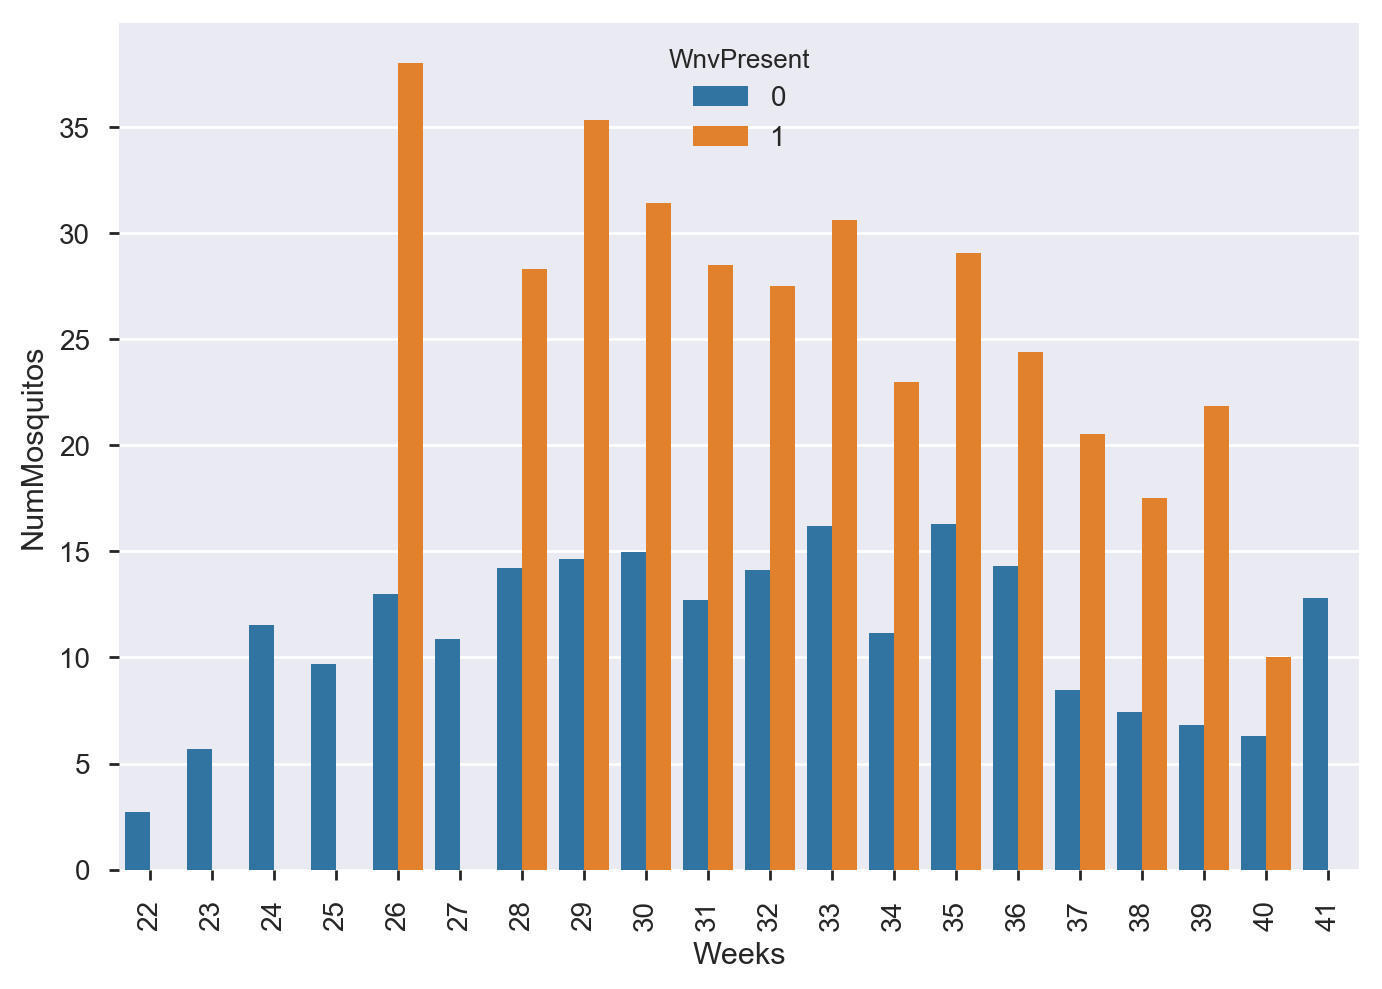

In [78]:
sns.barplot(x='Weeks',y='NumMosquitos',data=trw, hue='WnvPresent', ci=False)
plt.xticks(rotation=90) #not really much to get from this distribution with the number of mosquitos in each trap

Text(0,0.5,'Occurrences of West Nile Virus')

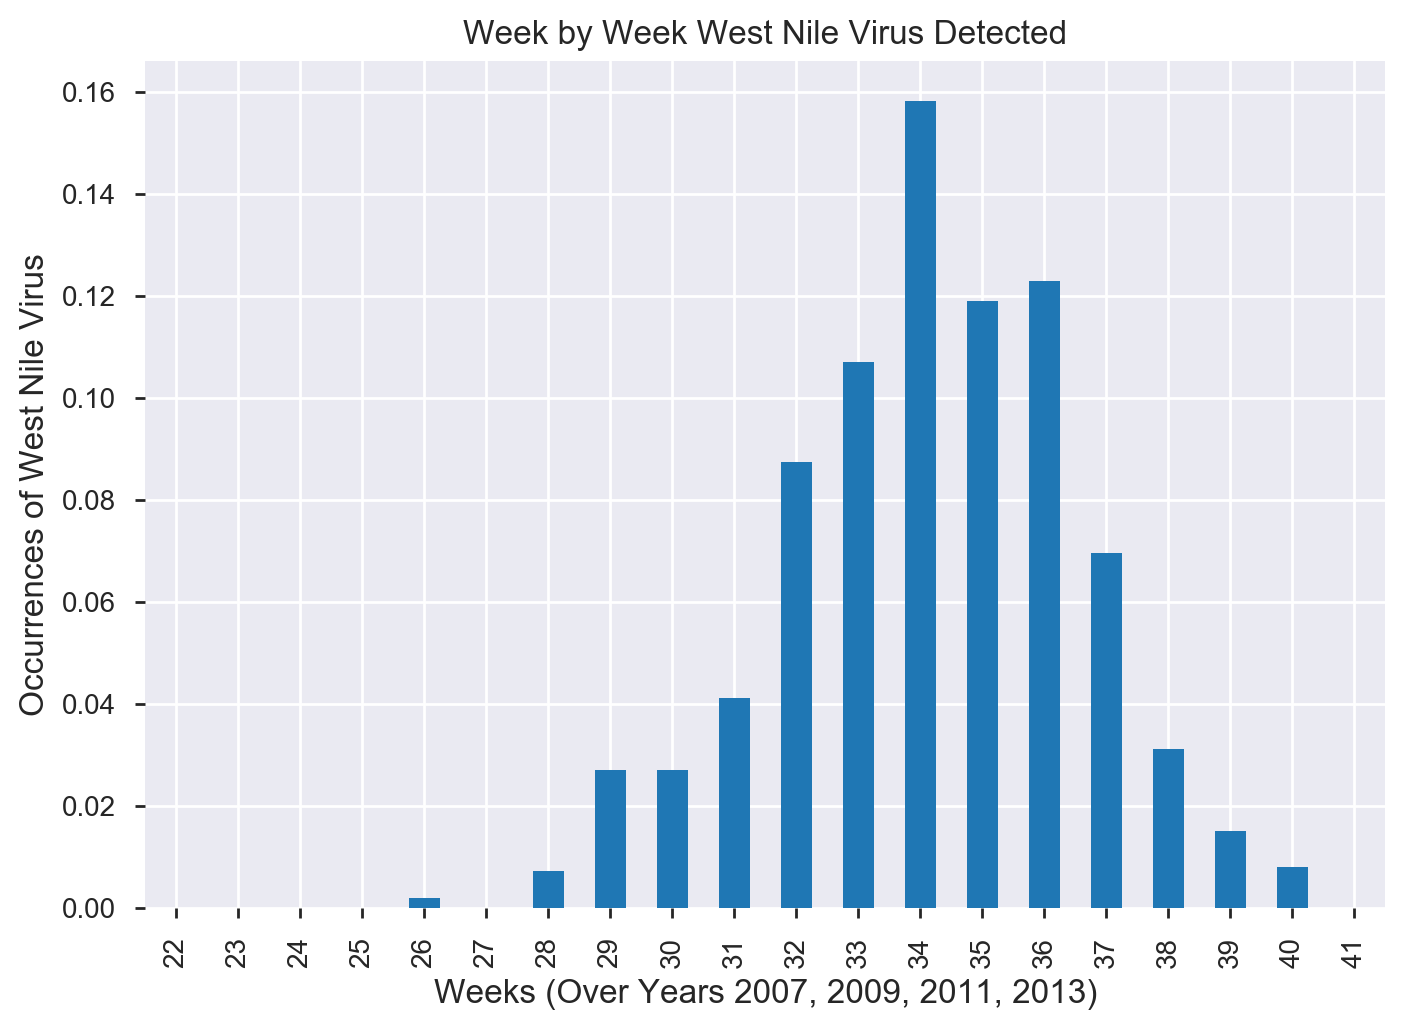

In [79]:
trw.groupby(['Weeks'])['WnvPresent'].mean().plot.bar()
plt.title("Week by Week West Nile Virus Detected", fontsize='large')
plt.xlabel("Weeks (Over Years 2007, 2009, 2011, 2013)", fontsize ='large')
plt.ylabel("Occurrences of West Nile Virus", fontsize='large')

Text(0,0.5,'Occurrences of West Nile Virus')

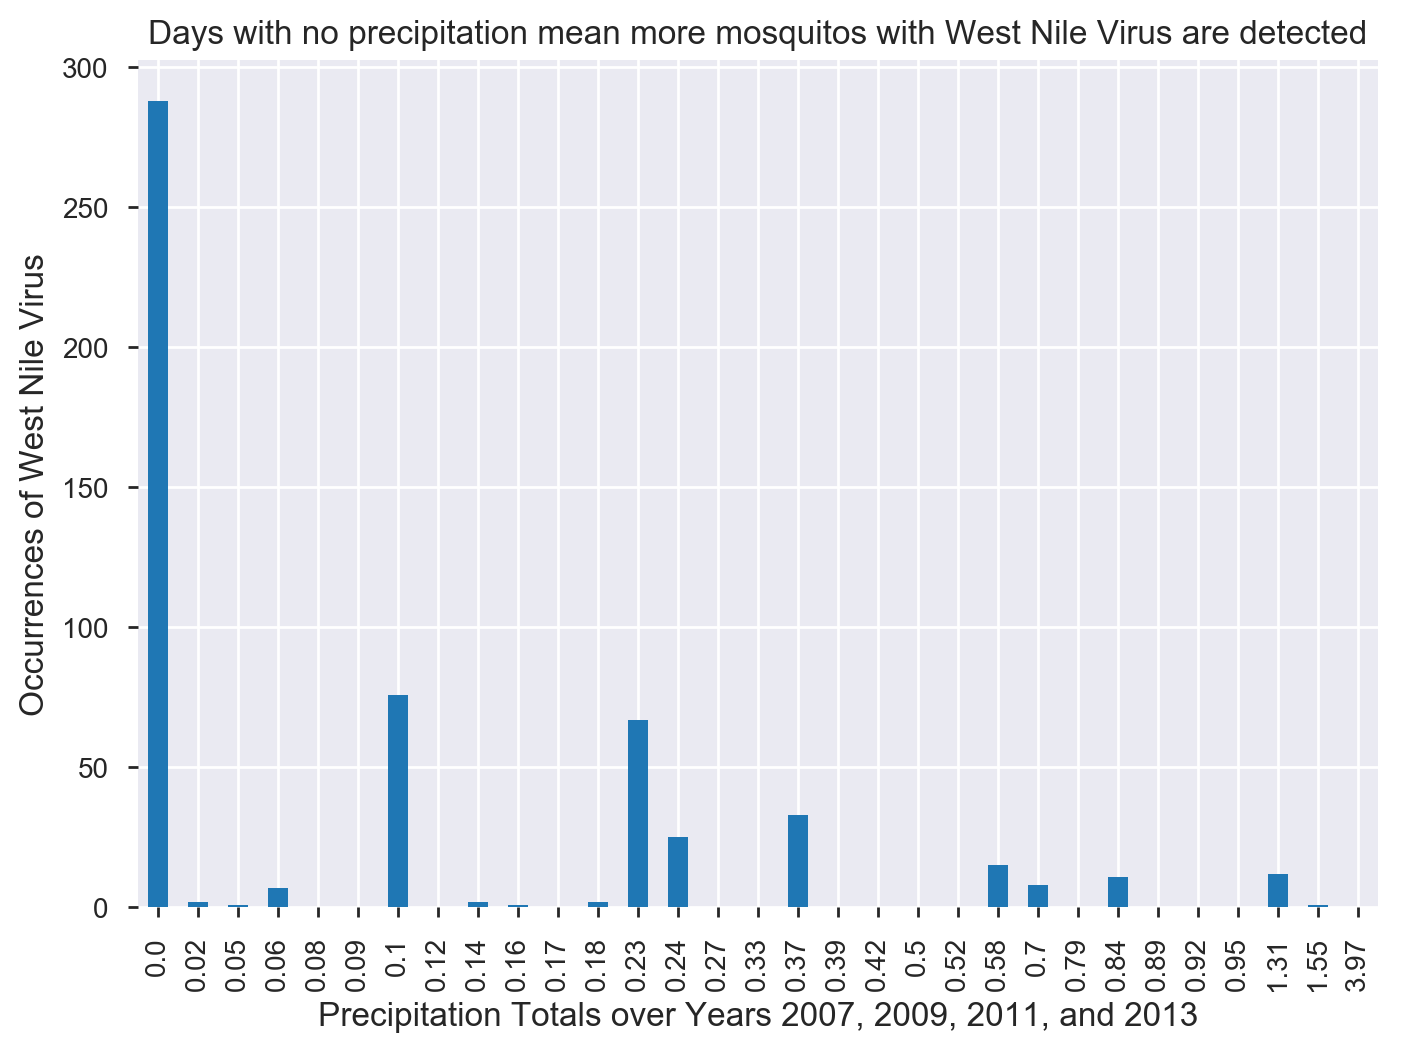

In [80]:
trw.groupby(['PrecipTotal'])['WnvPresent'].sum().plot.bar()
plt.title("Days with no precipitation mean more mosquitos with West Nile Virus are detected", fontsize='large')
plt.xlabel("Precipitation Totals over Years 2007, 2009, 2011, and 2013", fontsize ='large')
plt.ylabel("Occurrences of West Nile Virus", fontsize='large')

Text(0,0.5,'Occurrences of West Nile Virus')

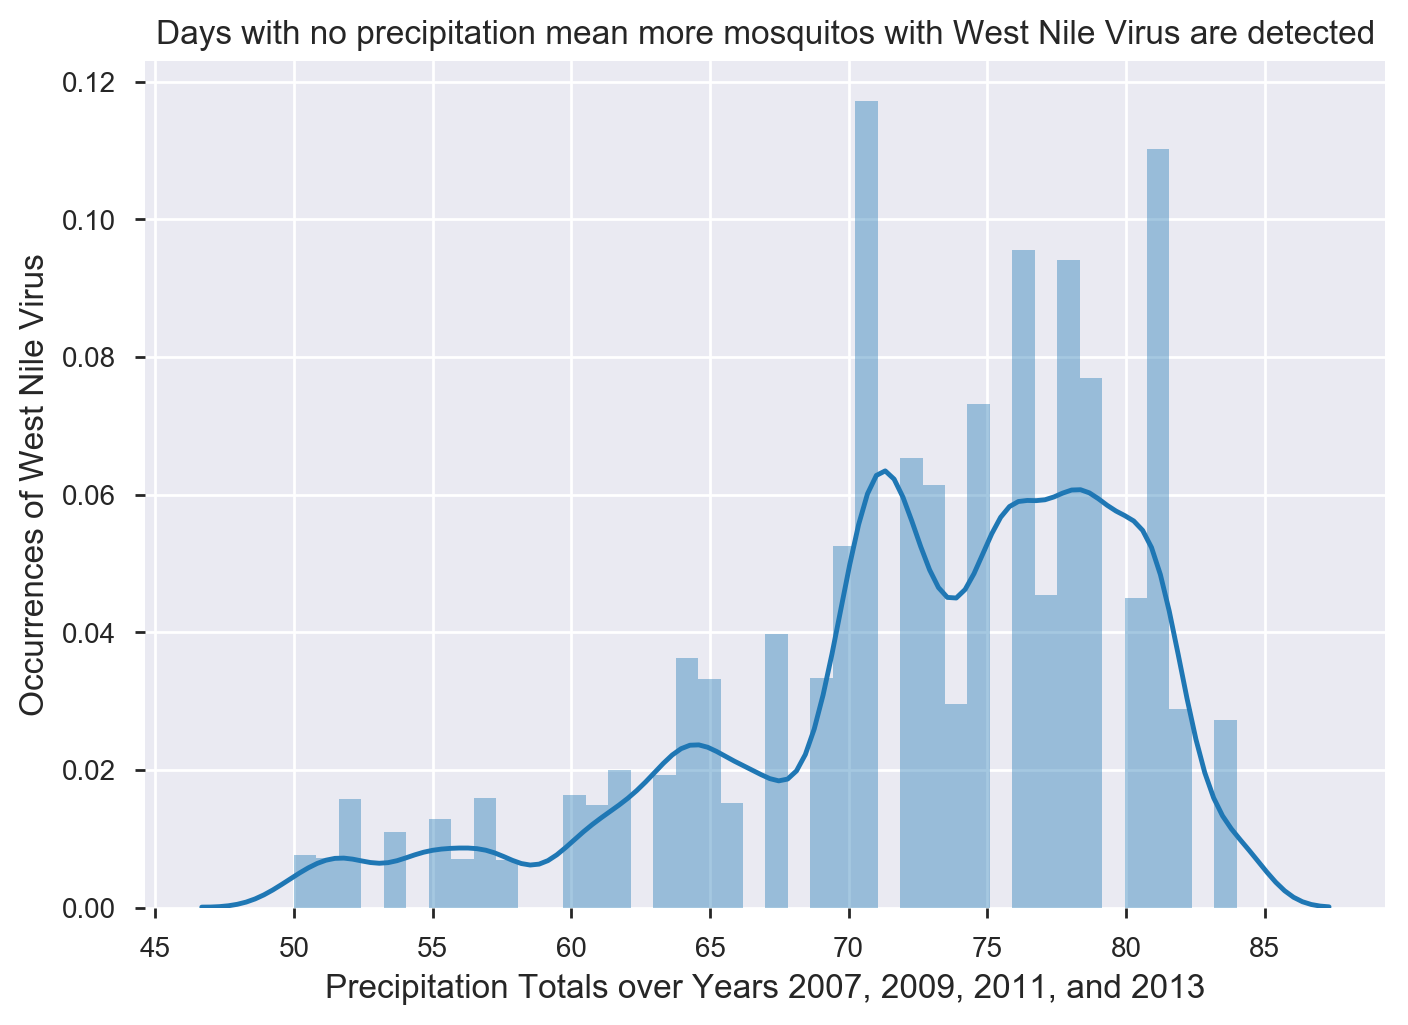

In [81]:
sns.distplot(trw.Tavg)
plt.title("Days with no precipitation mean more mosquitos with West Nile Virus are detected", fontsize='large')
plt.xlabel("Precipitation Totals over Years 2007, 2009, 2011, and 2013", fontsize ='large')
plt.ylabel("Occurrences of West Nile Virus", fontsize='large')

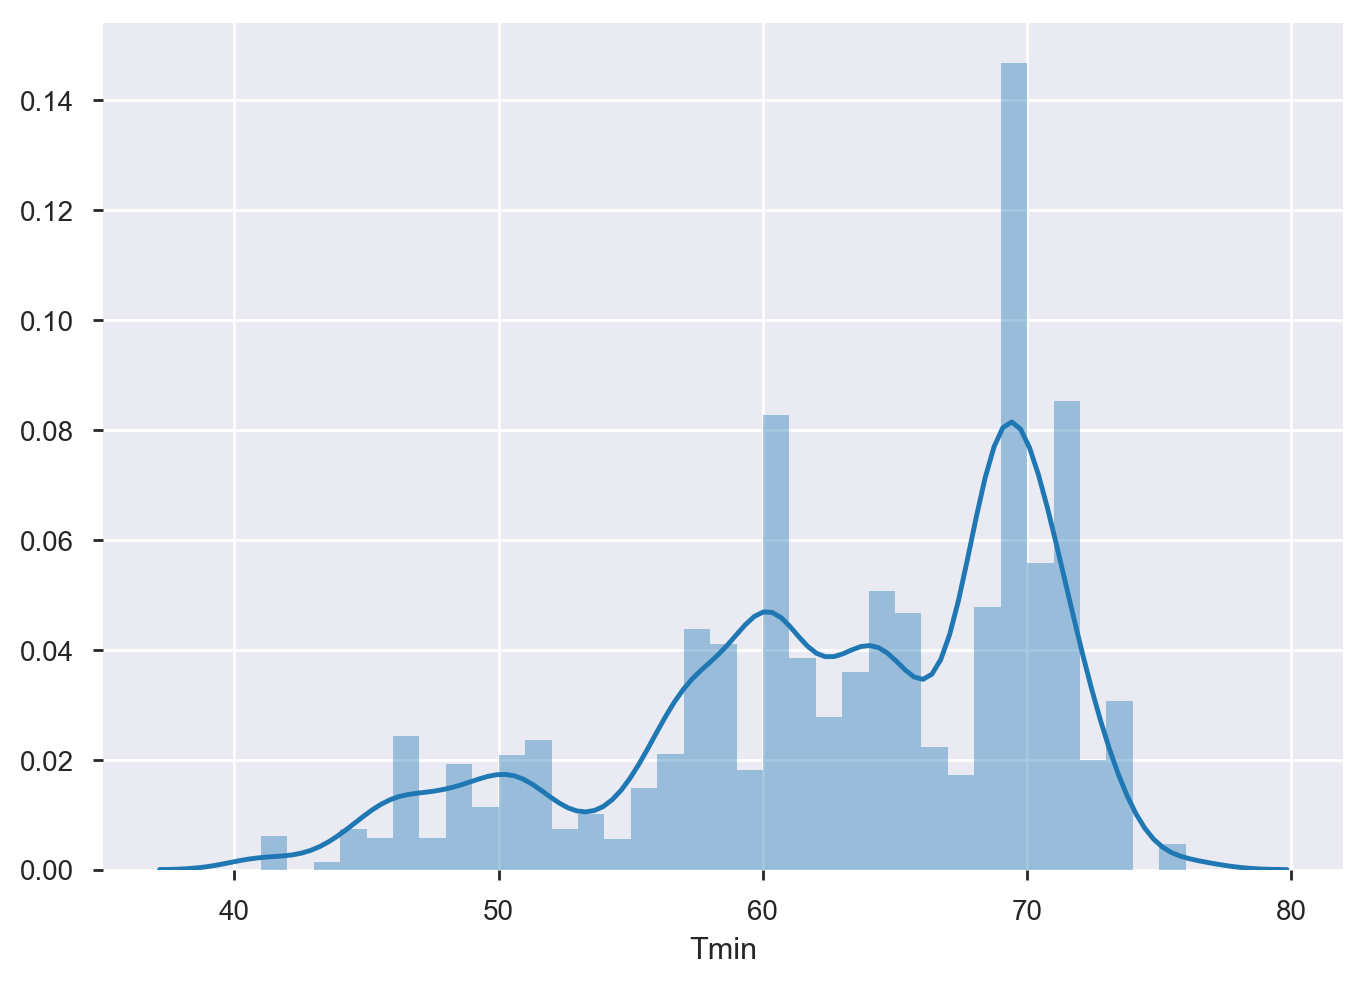

In [82]:
sns.distplot(trw.Tmin)

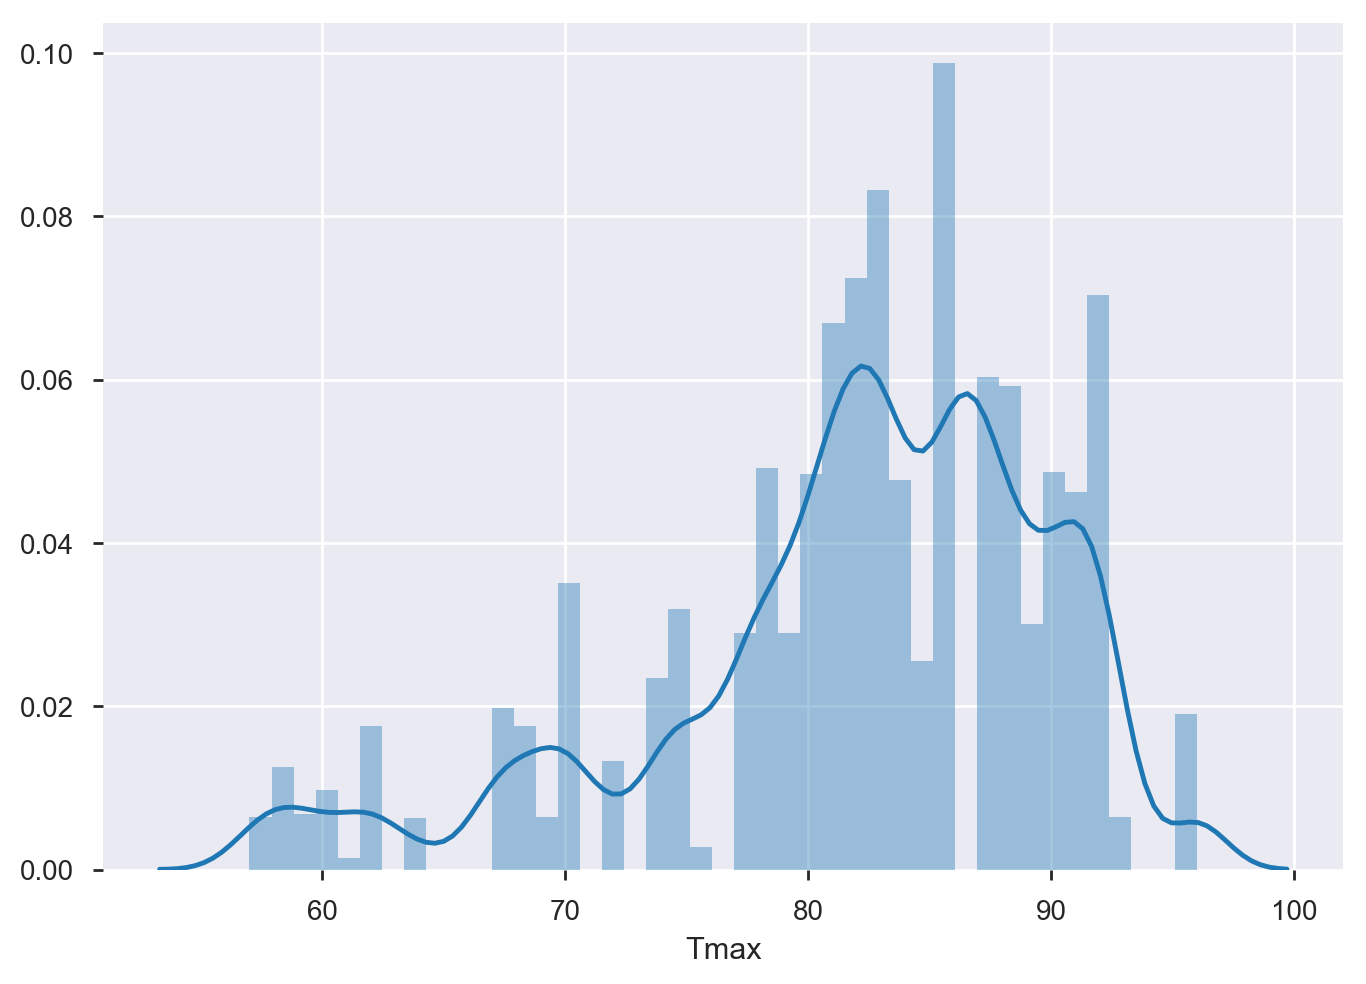

In [83]:
sns.distplot(trw.Tmax)

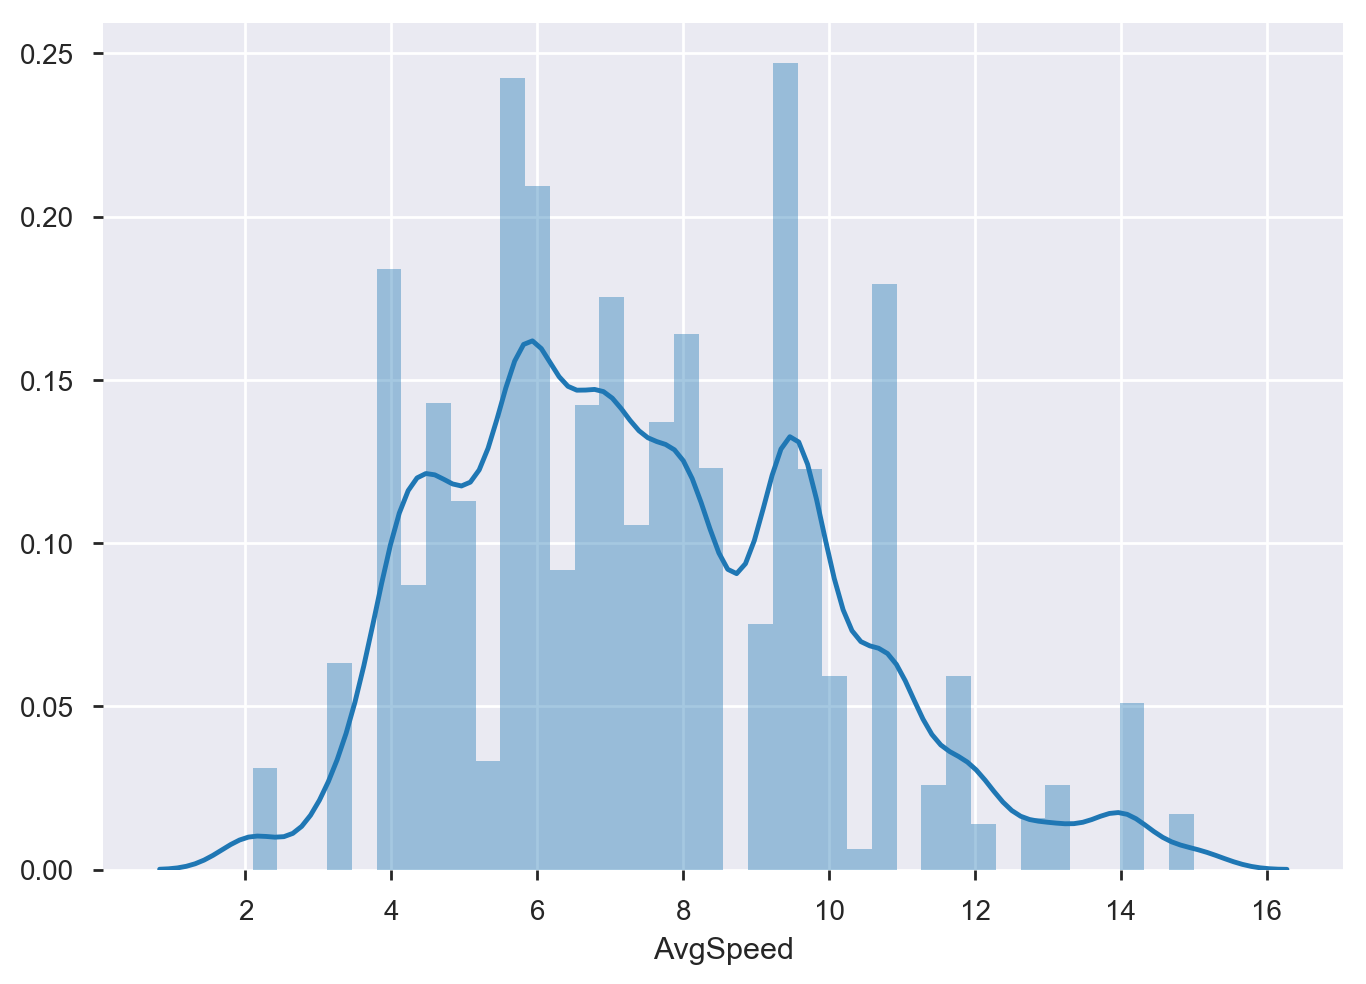

In [84]:
sns.distplot(trw.AvgSpeed)

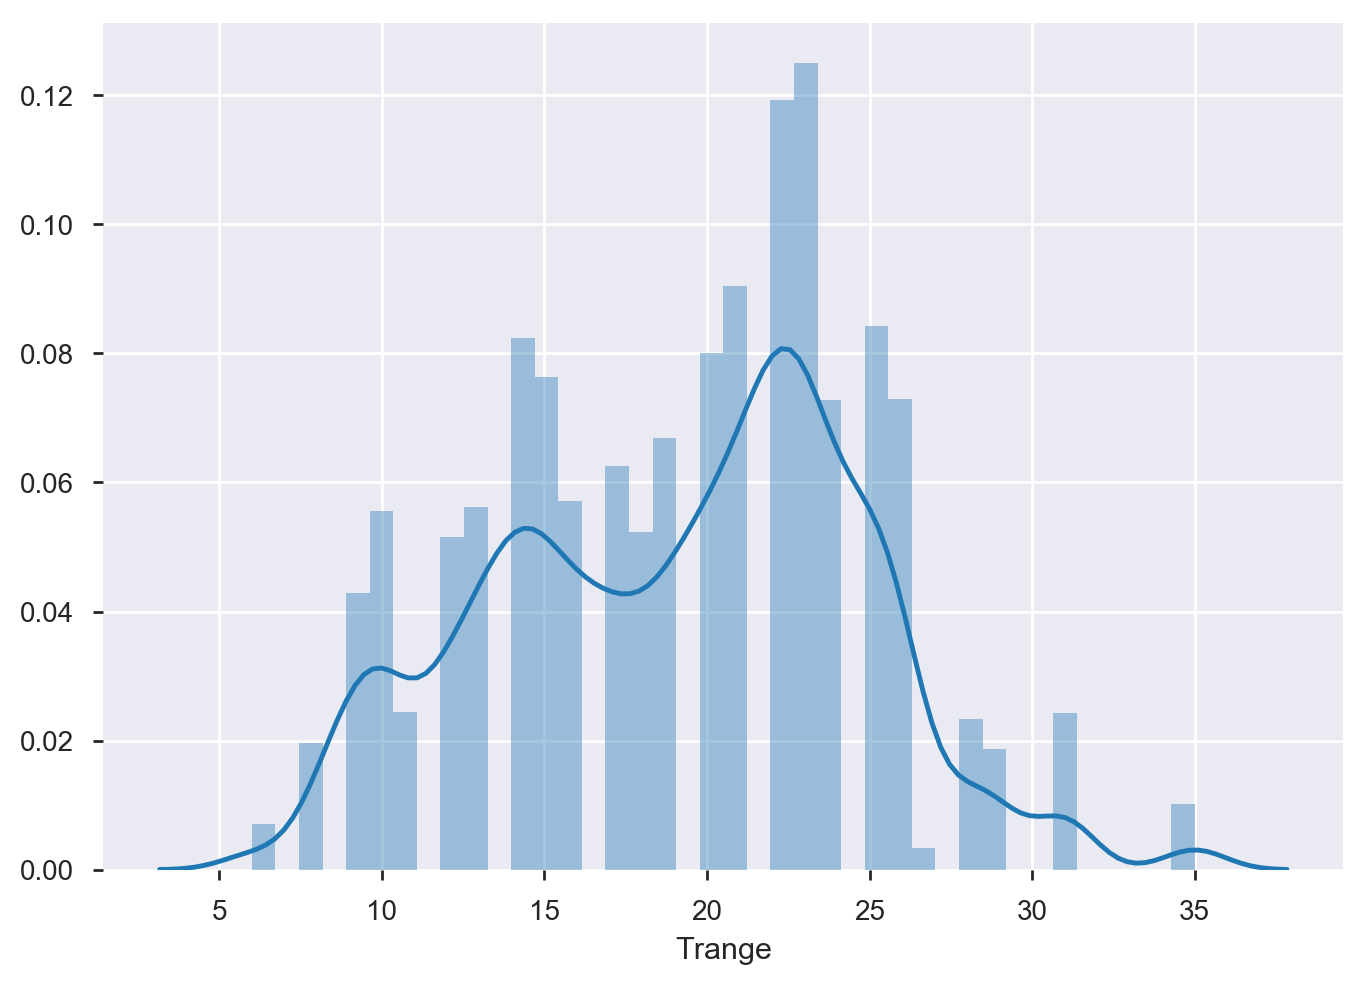

In [85]:
sns.distplot(trw.Trange)

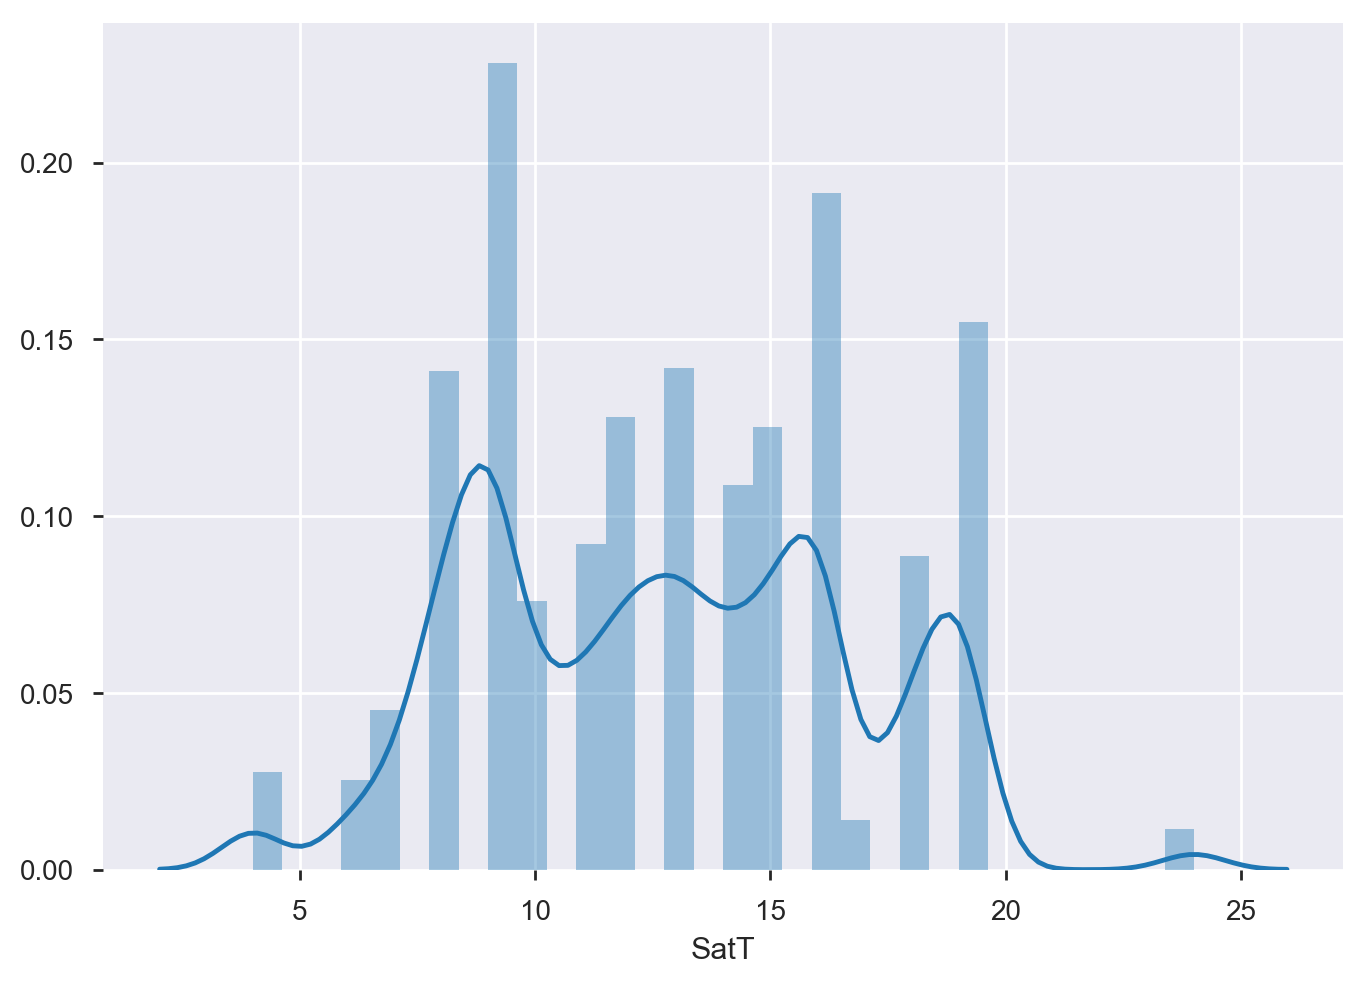

In [86]:
sns.distplot(trw.SatT)

### EDA takeaways

- There are values labeled as M (missing) and T (trace), we had to label the M values as missing as the M actually meant it was a missing value and T with a trace amount for the data series (the value depended on the data series itself). Some values had white space thath had to be removed. 
- Feature engineeringed new features such as the differences between the minimum and maximum averages, a binary variable of 0 and 1 for dew point if it was greater than 65 degrees (value of 1) and 0 for less than 55 degrees as a low dew point indicates a drier environment, and the difference between the dew point and the average temperature to determine humidity.
- Variables showing higher detections of west nile virus detection: zero precipitation total, higher dew point temperatures, higher wet bulb temperatures, higher temperatures, more mosquitos, higher humidity.
- Visualizations show that the virus was detected in the mosquito species of Culex Restuans, Culex Pipiens and Culex Restuans/Pipiens. Also, August had the highest detection frequency among the mosquitos. 